## Karar Destek Mekanizmaları

Veri setinden akademik personelin performansını ve başarılarını analiz ederek, çeşitli karar destek mekanizmaları oluşturmak.

In [66]:
# Gerekli kütüphanelerin yüklenmesi
%pip install pandas scikit-learn matplotlib seaborn
%pip install statsmodels
%pip install xgboost lightgbm
%pip install imbalanced-learn
%pip install scikit-optimize
%pip install tensorflow
%pip install setuptools
%pip install --upgrade setuptools


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [146]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
import warnings
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy import stats
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_regression



print("Kurulumlar başarılı!")

Kurulumlar başarılı!


In [68]:
# Excel dosyasını okuma
file_name = 'expdata.xlsx'
# DataFrame'i daha şık görüntüleme
df = pd.read_excel(file_name, engine='openpyxl') 
# Tablo görüntüleme
df.head()  

c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,30.11.2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,28.12.2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,28.03.2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023


In [69]:
# Veri setinin boyutlarını öğrenme
print(df.shape)

(29684, 11)


In [70]:
# Sütun adlarını ve veri tiplerini görüntüleme
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29684 entries, 0 to 29683
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               29684 non-null  int64 
 1   Akademik Personel Tipi  29684 non-null  object
 2   Cinsiyet Bilgisi        29684 non-null  object
 3   Ödüller                 29684 non-null  int64 
 4   Sunduğu bildiriler      29684 non-null  int64 
 5   Yayınlanmış makale      29684 non-null  int64 
 6   Aldığı atıflar          29684 non-null  int64 
 7   Kitap yazımı            29684 non-null  int64 
 8   Yaptığı editörlükler    29684 non-null  int64 
 9   Yönetilen tezler        29684 non-null  int64 
 10  Yıl                     29684 non-null  object
dtypes: int64(8), object(3)
memory usage: 2.5+ MB
None


In [71]:
# Eksik verileri kontrol etme
print(df.isnull().sum())

Person ID                 0
Akademik Personel Tipi    0
Cinsiyet Bilgisi          0
Ödüller                   0
Sunduğu bildiriler        0
Yayınlanmış makale        0
Aldığı atıflar            0
Kitap yazımı              0
Yaptığı editörlükler      0
Yönetilen tezler          0
Yıl                       0
dtype: int64


In [72]:
# Sütun adlarını görüntüleme
print("Orijinal Sütunlar:", df.columns)

Orijinal Sütunlar: Index(['Person ID', 'Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Ödüller',
       'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar',
       'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler', 'Yıl'],
      dtype='object')


In [73]:
# Veri setindeki kategorik ve sayısal değişkenleri ayırma
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Yıl'], dtype='object')
Sayısal Sütunlar: Index(['Person ID', 'Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale',
       'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler',
       'Yönetilen tezler'],
      dtype='object')


In [74]:
# Hatalı sonuç alamamak adına 'Person ID' sütununu kategorik veriye çevirme ve görüntüleme
df['Person ID'] = df['Person ID'].astype('object')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29684 entries, 0 to 29683
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               29684 non-null  object
 1   Akademik Personel Tipi  29684 non-null  object
 2   Cinsiyet Bilgisi        29684 non-null  object
 3   Ödüller                 29684 non-null  int64 
 4   Sunduğu bildiriler      29684 non-null  int64 
 5   Yayınlanmış makale      29684 non-null  int64 
 6   Aldığı atıflar          29684 non-null  int64 
 7   Kitap yazımı            29684 non-null  int64 
 8   Yaptığı editörlükler    29684 non-null  int64 
 9   Yönetilen tezler        29684 non-null  int64 
 10  Yıl                     29684 non-null  object
dtypes: int64(7), object(4)
memory usage: 2.5+ MB
None


In [75]:
# Kontrol
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['Person ID', 'Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Yıl'], dtype='object')
Sayısal Sütunlar: Index(['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar',
       'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler'],
      dtype='object')


In [76]:
# Kategorik sütunlar ve benzersiz değerlerin sayısını hesaplama
unique_counts = {
    'Person ID': len(df['Person ID'].unique()),
    'Akademik Personel Tipi': len(df['Akademik Personel Tipi'].unique()),
    'Cinsiyet Bilgisi': len(df['Cinsiyet Bilgisi'].unique()),
    'Yıl': len(df['Yıl'].unique()),
}

# Sonuçları yazdırma
print("Kategorik Sütunların Benzersiz Değer Sayıları:")
for column, count in unique_counts.items():
    print(f"{column}: {count} benzersiz değer")

Kategorik Sütunların Benzersiz Değer Sayıları:
Person ID: 1078 benzersiz değer
Akademik Personel Tipi: 10 benzersiz değer
Cinsiyet Bilgisi: 2 benzersiz değer
Yıl: 3840 benzersiz değer


In [77]:
# Yıl kısmını yakından inceleme
unique_values_yil = df['Yıl'].unique()
print({textwrap.fill(', '.join(unique_values_yil))})

{'30.11.2018, 28.12.2023, 28.03.2022, 2023, 2022, 2021, 2020, 2019,\n2018, 2017, 2016, 18.11.2016, 16.04.2017, 12.09.2017, 11.10.2017,\n10.03.2018, 01.12.2018, 20.10.2019, 13.11.2018, 2012, 26.04.2015,\n25.06.2014, 2015, 2014, 2013, 2011, 2010, 2009, 2008, 2007, 2006,\n2005, 2004, 2003, 2001, 2000, 1998, 19.12.2020, 19.10.2018,\n15.09.2021, 14.05.2016, 12.05.2019, 30.09.2018, 30.07.2021,\n27.09.2017, 26.09.2018, 25.09.2017, 2002, 17.05.2018, 13.05.2018,\n12.05.2018, 09.09.2018, 08.12.2019, 06.09.2018, 30.12.2018,\n30.10.2017, 30.09.2017, 30.04.2017, 29.10.2018, 27.09.2018,\n26.04.2017, 23.12.2018, 22.09.2019, 20.12.2018, 19.09.2019,\n14.09.2017, 14.09.2016, 13.12.2018, 01.12.2017, 01.09.2019,\n01.06.2017, 17.11.2019, 02.11.2010, 28.05.2008, 26.08.2007,\n25.09.2002, 25.06.2003, 24.10.2018, 24.05.2006, 23.04.2009, 2024,\n20.04.2007, 17.09.2014, 17.05.2007, 15.10.2023, 15.06.2007,\n12.04.2007, 09.10.2017, 05.09.2007, 04.09.2007, 02.11.2007,\n01.07.2007, 23.04.2016, 31.08.2019, 28.10.2015,

In [78]:
# Yıl sütunundan gün-ay-yıl ve sadece yıl ayırma işlemi
def extract_year(date_str):
    try:
        # Tarih değerini ayırma
        date_parts = date_str.split('.')
        if len(date_parts) == 3:
            # Gün-ay-yıl formatında, sadece yılı alma
            return date_parts[-1]
        elif len(date_parts) == 1:
            # Yalnızca yıl formatında
            return date_str
        else:
            # Geçersiz format
            return np.nan
    except Exception as e:
        print(f"Error processing {date_str}: {e}")
        return np.nan

# Yeni yıl sütunu oluşturma
df['Yıl(Güncellenmiş)'] = df['Yıl'].apply(extract_year)

df.head()

,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl,Yıl(Güncellenmiş)
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,30.11.2018,2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,28.12.2023,2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,28.03.2022,2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023,2023


In [79]:
# Eski Yıl sütunun atma
df = df.drop(columns=['Yıl'])

# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
df.to_csv('cleaned_data_year.csv', index=False)
df.head()

,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl(Güncellenmiş)
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023


In [80]:
# Kategorik sütunlar ve benzersiz değerlerin sayısını yeniden hesaplama
unique_counts = {
    'Person ID': len(df['Person ID'].unique()),
    'Akademik Personel Tipi': len(df['Akademik Personel Tipi'].unique()),
    'Cinsiyet Bilgisi': len(df['Cinsiyet Bilgisi'].unique()),
    'Yıl': len(df['Yıl(Güncellenmiş)'].unique()),
}

# Sonuçları yazdırma
print("Kategorik Sütunların Benzersiz Değer Sayıları:")
for column, count in unique_counts.items():
    print(f"{column}: {count} benzersiz değer")

Kategorik Sütunların Benzersiz Değer Sayıları:
Person ID: 1078 benzersiz değer
Akademik Personel Tipi: 10 benzersiz değer
Cinsiyet Bilgisi: 2 benzersiz değer
Yıl: 64 benzersiz değer


In [81]:
# Hata kontrolü için kategorik veri içeren sütunların benzersiz değerlerinin görüntülenmesi
# Benzersiz değerlerin listesi

unique_values_person = map(str,df['Person ID'].unique())
unique_values_personel = df['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df['Cinsiyet Bilgisi'].unique()
unique_values_yil = df['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 384, 396, 399, 400, 401, 406, 417, 418, 420, 439, 443, 444, 445, 447, 449, 452, 453, 454, 455, 457, 458, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1103, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1123, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344,
1362, 1382, 1384, 1390, 1404, 1407, 1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 

In [82]:
# Yıl sütununda geçerli değerleri filtreleme
def is_valid_year(year_str):
    try:
        year = int(year_str)
        # Yılın dört basamaktan oluştuğundan ve makul bir aralıkta olduğundan emin olma
        return 1900 <= year <= 2100
    except ValueError:
        return False

# Geçerli yıl değerlerini içeren yeni DataFrame oluşturma
df = df[df['Yıl(Güncellenmiş)'].apply(is_valid_year)]

In [83]:
# Yeniden benzeriz değer görüntüleme

unique_values_person = map(str,df['Person ID'].unique())
unique_values_personel = df['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df['Cinsiyet Bilgisi'].unique()
unique_values_yil = df['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 384, 396, 399, 400, 401, 406, 417, 418, 420, 439, 443, 444, 445, 447, 449, 452, 453, 454, 455, 457, 458, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1103, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1123, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344,
1362, 1382, 1384, 1390, 1404, 1407, 1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 

In [84]:
# Satır tekrarı kontrolü 
# Tekrar eden satırları belirleme
duplicates = df[df.duplicated()]
print(duplicates)

      Person ID Akademik Personel Tipi Cinsiyet Bilgisi  Ödüller  \
4           124    Araştırma Görevlisi            Kadın        0   
6           124    Araştırma Görevlisi            Kadın        0   
7           124    Araştırma Görevlisi            Kadın        0   
9           124    Araştırma Görevlisi            Kadın        0   
10          124    Araştırma Görevlisi            Kadın        0   
...         ...                    ...              ...      ...   
29668   1181872   Doktor Öğretim Üyesi            Erkek        0   
29669   1181872   Doktor Öğretim Üyesi            Erkek        0   
29670   1181872   Doktor Öğretim Üyesi            Erkek        0   
29671   1181872   Doktor Öğretim Üyesi            Erkek        0   
29683   1182250   Doktor Öğretim Üyesi            Kadın        0   

       Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  Kitap yazımı  \
4                       0                   0              24             6   
6                       0

In [85]:
# Tekrar eden satırları kaldırma
df = df.drop_duplicates()
print(df)

      Person ID Akademik Personel Tipi Cinsiyet Bilgisi  Ödüller  \
0           124    Araştırma Görevlisi            Kadın        0   
1           124    Araştırma Görevlisi            Kadın        0   
2           124    Araştırma Görevlisi            Kadın        0   
3           124    Araştırma Görevlisi            Kadın        0   
5           124    Araştırma Görevlisi            Kadın        0   
...         ...                    ...              ...      ...   
29678   1182250   Doktor Öğretim Üyesi            Kadın        0   
29679   1182250   Doktor Öğretim Üyesi            Kadın        0   
29680   1182250   Doktor Öğretim Üyesi            Kadın        0   
29681   1182250   Doktor Öğretim Üyesi            Kadın        0   
29682   1182250   Doktor Öğretim Üyesi            Kadın        0   

       Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  Kitap yazımı  \
0                       2                   0               0             0   
1                      19

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18178 entries, 0 to 29682
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               18178 non-null  object
 1   Akademik Personel Tipi  18178 non-null  object
 2   Cinsiyet Bilgisi        18178 non-null  object
 3   Ödüller                 18178 non-null  int64 
 4   Sunduğu bildiriler      18178 non-null  int64 
 5   Yayınlanmış makale      18178 non-null  int64 
 6   Aldığı atıflar          18178 non-null  int64 
 7   Kitap yazımı            18178 non-null  int64 
 8   Yaptığı editörlükler    18178 non-null  int64 
 9   Yönetilen tezler        18178 non-null  int64 
 10  Yıl(Güncellenmiş)       18178 non-null  object
dtypes: int64(7), object(4)
memory usage: 1.7+ MB


In [87]:
# Aynı Person ID ve Yıl içeren satırları grupla ve toplama işlemi yap
df = df.groupby(['Person ID', 'Yıl(Güncellenmiş)'], as_index=False).agg({
    'Akademik Personel Tipi': 'first',  # İlk değeri al
    'Cinsiyet Bilgisi': 'first',         # İlk değeri al 
    'Ödüller': 'sum',
    'Sunduğu bildiriler': 'sum',
    'Yayınlanmış makale': 'sum',
    'Aldığı atıflar': 'sum',
    'Kitap yazımı': 'sum',
    'Yaptığı editörlükler': 'sum',
    'Yönetilen tezler': 'sum'
})

# Sonuçları kontrol et
df.head()

,Person ID,Yıl(Güncellenmiş),Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
0,124,2016,Araştırma Görevlisi,Kadın,0,2,1,0,0,0,0
1,124,2017,Araştırma Görevlisi,Kadın,0,3,8,0,2,0,0
2,124,2018,Araştırma Görevlisi,Kadın,0,3,1,0,0,0,0
3,124,2019,Araştırma Görevlisi,Kadın,0,0,5,0,0,0,0
4,124,2020,Araştırma Görevlisi,Kadın,0,0,3,6,8,0,0


In [88]:
# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
df.to_csv('cleaned_data_year.csv', index=False)
df.head()

,Person ID,Yıl(Güncellenmiş),Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
0,124,2016,Araştırma Görevlisi,Kadın,0,2,1,0,0,0,0
1,124,2017,Araştırma Görevlisi,Kadın,0,3,8,0,2,0,0
2,124,2018,Araştırma Görevlisi,Kadın,0,3,1,0,0,0,0
3,124,2019,Araştırma Görevlisi,Kadın,0,0,5,0,0,0,0
4,124,2020,Araştırma Görevlisi,Kadın,0,0,3,6,8,0,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11691 entries, 0 to 11690
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               11691 non-null  object
 1   Yıl(Güncellenmiş)       11691 non-null  object
 2   Akademik Personel Tipi  11691 non-null  object
 3   Cinsiyet Bilgisi        11691 non-null  object
 4   Ödüller                 11691 non-null  int64 
 5   Sunduğu bildiriler      11691 non-null  int64 
 6   Yayınlanmış makale      11691 non-null  int64 
 7   Aldığı atıflar          11691 non-null  int64 
 8   Kitap yazımı            11691 non-null  int64 
 9   Yaptığı editörlükler    11691 non-null  int64 
 10  Yönetilen tezler        11691 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1004.8+ KB


In [90]:
# Veri setinin istatistiksel özetini alma
print(df.describe())

            Ödüller  Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  \
count  11691.000000        11691.000000        11691.000000    11691.000000   
mean       0.565478            2.616286            4.173723        2.733641   
std        4.071964            9.786640           11.603472       12.009536   
min        0.000000            0.000000            0.000000        0.000000   
25%        0.000000            0.000000            0.000000        0.000000   
50%        0.000000            0.000000            2.000000        0.000000   
75%        0.000000            1.000000            4.000000        0.000000   
max      202.000000          313.000000          320.000000      546.000000   

       Kitap yazımı  Yaptığı editörlükler  Yönetilen tezler  
count  11691.000000          11691.000000      11691.000000  
mean       1.657087              0.663844          1.184586  
std        8.673393              5.516775          6.541711  
min        0.000000              0.00000

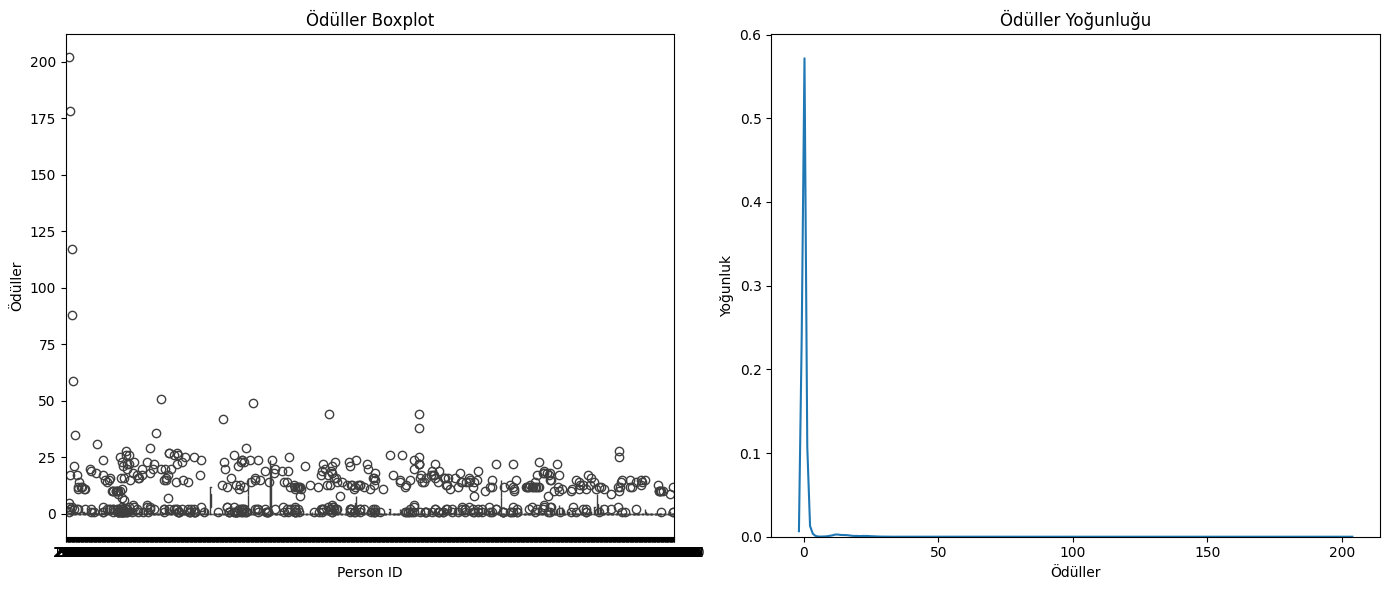

In [91]:
# Temizlenmiş veri ile boxplot ve KDE grafiği oluşturma
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Örnek: Ödüller
# Boxplot
sns.boxplot(x='Person ID', y='Ödüller', data=df, ax=axes[0])
axes[0].set_title('Ödüller Boxplot')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Ödüller')

# KDE grafiği
sns.kdeplot(df['Ödüller'], ax=axes[1])
axes[1].set_xlabel('Ödüller')
axes[1].set_ylabel('Yoğunluk')
axes[1].set_title('Ödüller Yoğunluğu')

plt.tight_layout()
plt.show()



In [92]:
# Sayısal verilerin kontrolünde yanlış veya hatalı girilmiş olabilecek değerler keşfedildi (Çok sayıda outlier).
# Konu ile ilgili araştırma yapıldıktan sonra sınırlar belirlendi ve veri sınırlara göre yeniden düzenlendi.

In [93]:
# İlk veri setinden temizlenmiş veri oluşturma
df_cleaned = df.copy()

# Ödüller için özel sınırlar
valid_awards = (df_cleaned['Ödüller'] >= 0) & (df_cleaned['Ödüller'] <= 5)
df_cleaned = df_cleaned[valid_awards]

# Bildiri Sunma için sınır
valid_presentations = (df_cleaned['Sunduğu bildiriler'] >= 0) & (df_cleaned['Sunduğu bildiriler'] <= 20)
df_cleaned = df_cleaned[valid_presentations]

# Makale Yayınlama için sınır
valid_publications = (df_cleaned['Yayınlanmış makale'] >= 0) & (df_cleaned['Yayınlanmış makale'] <= 20)
df_cleaned = df_cleaned[valid_publications]

# Atıf için sınır
valid_citations = (df_cleaned['Aldığı atıflar'] >= 0) & (df_cleaned['Aldığı atıflar'] <= 100)
df_cleaned = df_cleaned[valid_citations]

# Kitap Yazma için sınır
valid_books = df_cleaned['Kitap yazımı'] < 5
df_cleaned = df_cleaned[valid_books]

# Editörlük için sınır
valid_editorship = (df_cleaned['Yaptığı editörlükler'] >= 0) & (df_cleaned['Yaptığı editörlükler'] <= 5)
df_cleaned = df_cleaned[valid_editorship]

# Tez Yönetimi için sınır
valid_thesis_supervision = (df_cleaned['Yönetilen tezler'] >= 0) & (df_cleaned['Yönetilen tezler'] <= 10)
df_cleaned = df_cleaned[valid_thesis_supervision]

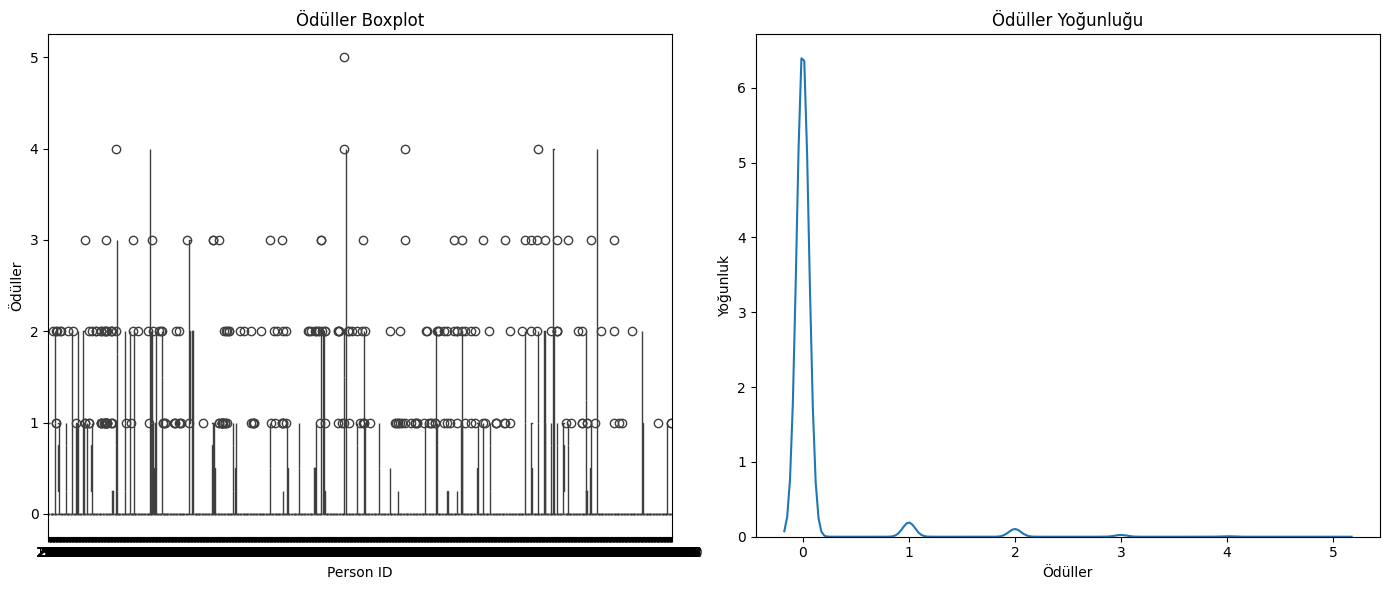

In [94]:
# Temizlenmiş veri ile boxplot ve KDE grafiği oluşturma
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(x='Person ID', y='Ödüller', data=df_cleaned, ax=axes[0])
axes[0].set_title('Ödüller Boxplot')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Ödüller')

# KDE grafiği
sns.kdeplot(df_cleaned['Ödüller'], ax=axes[1])
axes[1].set_xlabel('Ödüller')
axes[1].set_ylabel('Yoğunluk')
axes[1].set_title('Ödüller Yoğunluğu')

plt.tight_layout()
plt.show()


In [95]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9448 entries, 0 to 11689
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               9448 non-null   object
 1   Yıl(Güncellenmiş)       9448 non-null   object
 2   Akademik Personel Tipi  9448 non-null   object
 3   Cinsiyet Bilgisi        9448 non-null   object
 4   Ödüller                 9448 non-null   int64 
 5   Sunduğu bildiriler      9448 non-null   int64 
 6   Yayınlanmış makale      9448 non-null   int64 
 7   Aldığı atıflar          9448 non-null   int64 
 8   Kitap yazımı            9448 non-null   int64 
 9   Yaptığı editörlükler    9448 non-null   int64 
 10  Yönetilen tezler        9448 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 885.8+ KB


Cinsiyet Bilgisi üzerine çalışma

In [96]:
# Cinsiyet ve diğer değişkenlerle ilgili alt veri seti oluşturma
variables_of_interest = ['Cinsiyet Bilgisi', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']
df_subset = df_cleaned[variables_of_interest]

In [97]:
# Cinsiyete göre özet istatistikleri hesaplama
summary_stats = df_subset.groupby('Cinsiyet Bilgisi').describe()
print(summary_stats)


                 Sunduğu bildiriler                                          \
                              count      mean       std  min  25%  50%  75%   
Cinsiyet Bilgisi                                                              
Erkek                        5501.0  1.510453  3.375221  0.0  0.0  0.0  1.0   
Kadın                        3947.0  1.704586  3.477738  0.0  0.0  0.0  1.0   

                       Yayınlanmış makale            ... Yaptığı editörlükler  \
                   max              count      mean  ...                  75%   
Cinsiyet Bilgisi                                     ...                        
Erkek             20.0             5501.0  2.792583  ...                  0.0   
Kadın             20.0             3947.0  2.894097  ...                  0.0   

                      Yönetilen tezler                                     \
                  max            count      mean       std  min  25%  50%   
Cinsiyet Bilgisi                            

In [98]:
# Ortalama
df_cleaned.groupby('Cinsiyet Bilgisi')[['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']].mean()

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Cinsiyet Bilgisi,,,,,,,
Erkek,0.061807,1.510453,2.792583,1.900745,0.314852,0.089802,0.354299
Kadın,0.086901,1.704586,2.894097,2.227515,0.319230,0.041551,0.241703


In [99]:
# Standart Sapma
df_cleaned.groupby('Cinsiyet Bilgisi')[['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']].std()

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Cinsiyet Bilgisi,,,,,,,
Erkek,0.331659,3.375221,3.888312,5.348063,0.764041,0.436023,1.003129
Kadın,0.399947,3.477738,4.015294,6.014969,0.774625,0.266943,0.887118


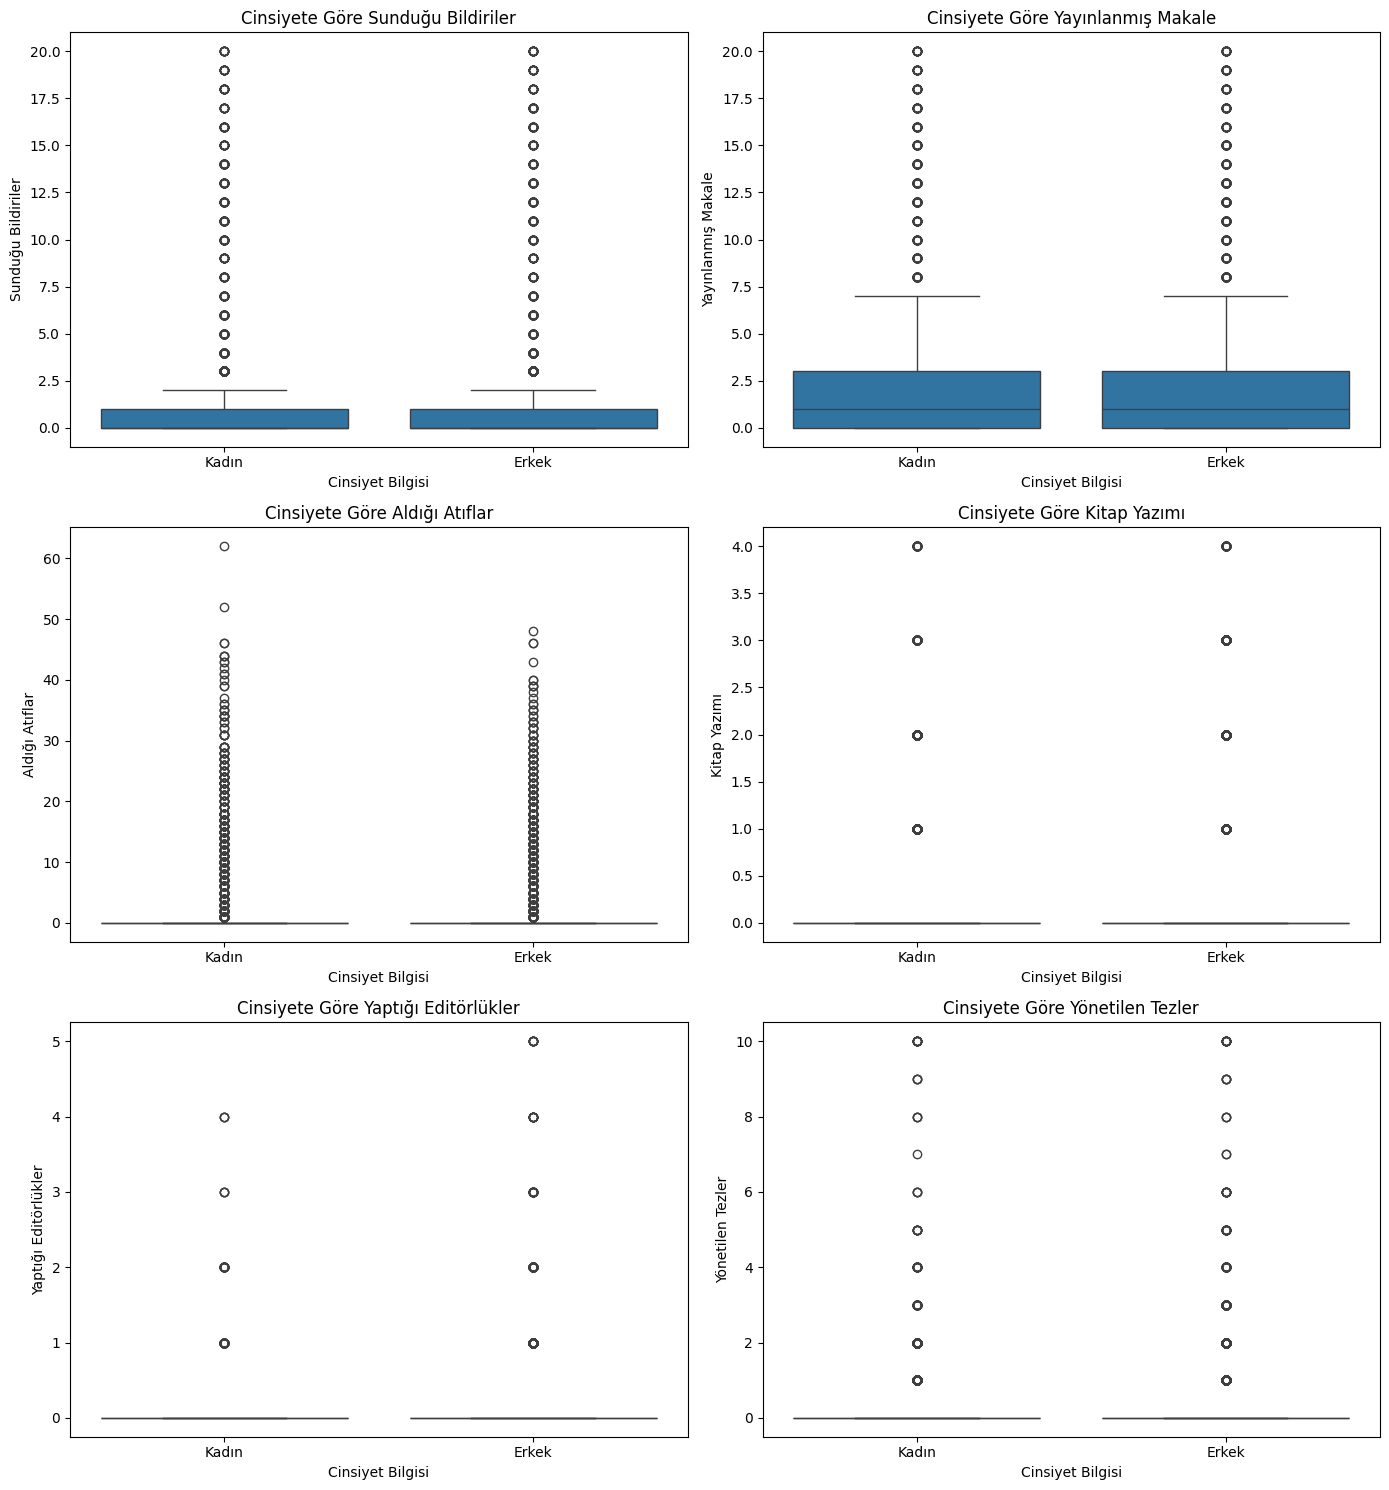

In [100]:
# Temizlenmiş veri ile görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Sunduğu Bildiriler
sns.boxplot(x='Cinsiyet Bilgisi', y='Sunduğu bildiriler', data=df_subset, ax=axes[0, 0])
axes[0, 0].set_title('Cinsiyete Göre Sunduğu Bildiriler')
axes[0, 0].set_xlabel('Cinsiyet Bilgisi')
axes[0, 0].set_ylabel('Sunduğu Bildiriler')

# Yayınlanmış Makale
sns.boxplot(x='Cinsiyet Bilgisi', y='Yayınlanmış makale', data=df_subset, ax=axes[0, 1])
axes[0, 1].set_title('Cinsiyete Göre Yayınlanmış Makale')
axes[0, 1].set_xlabel('Cinsiyet Bilgisi')
axes[0, 1].set_ylabel('Yayınlanmış Makale')

# Aldığı Atıflar
sns.boxplot(x='Cinsiyet Bilgisi', y='Aldığı atıflar', data=df_subset, ax=axes[1, 0])
axes[1, 0].set_title('Cinsiyete Göre Aldığı Atıflar')
axes[1, 0].set_xlabel('Cinsiyet Bilgisi')
axes[1, 0].set_ylabel('Aldığı Atıflar')

# Kitap Yazımı
sns.boxplot(x='Cinsiyet Bilgisi', y='Kitap yazımı', data=df_subset, ax=axes[1, 1])
axes[1, 1].set_title('Cinsiyete Göre Kitap Yazımı')
axes[1, 1].set_xlabel('Cinsiyet Bilgisi')
axes[1, 1].set_ylabel('Kitap Yazımı')

# Editörlük
sns.boxplot(x='Cinsiyet Bilgisi', y='Yaptığı editörlükler', data=df_subset, ax=axes[2, 0])
axes[2, 0].set_title('Cinsiyete Göre Yaptığı Editörlükler')
axes[2, 0].set_xlabel('Cinsiyet Bilgisi')
axes[2, 0].set_ylabel('Yaptığı Editörlükler')

# Tez Yönetimi
sns.boxplot(x='Cinsiyet Bilgisi', y='Yönetilen tezler', data=df_subset, ax=axes[2, 1])
axes[2, 1].set_title('Cinsiyete Göre Yönetilen Tezler')
axes[2, 1].set_xlabel('Cinsiyet Bilgisi')
axes[2, 1].set_ylabel('Yönetilen Tezler')

plt.tight_layout()
plt.show()


In [101]:
# 'Ödüller' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
male_awards = df_subset[df_subset['Cinsiyet Bilgisi'] == 'Erkek']['Sunduğu bildiriler']
female_awards = df_subset[df_subset['Cinsiyet Bilgisi'] == 'Kadın']['Sunduğu bildiriler']

t_stat, p_val = stats.ttest_ind(male_awards, female_awards, nan_policy='omit')
print(f"Ödüller için T-Testi: : t-stat =  {t_stat:.3f}, p-Değeri: {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(male_awards, female_awards, alternative='two-sided')
print(f"Ödüller için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Ödüller için T-Testi: : t-stat =  -2.722, p-Değeri: 0.006
Ödüller için Mann-Whitney U Testi: U-stat = 10263202.000, p-değeri = 0.000


In [102]:
# 'Sunduğu bildiriler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Sunduğu bildiriler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Sunduğu bildiriler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Sunduğu bildiriler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Sunduğu bildiriler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Sunduğu bildiriler için T-Testi: t-stat = -2.722, p-değeri = 0.006
Sunduğu bildiriler için Mann-Whitney U Testi: U-stat = 10263202.000, p-değeri = 0.000


In [103]:
# 'Yayınlanmış makale' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yayınlanmış makale']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yayınlanmış makale']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yayınlanmış makale için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yayınlanmış makale için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yayınlanmış makale için T-Testi: t-stat = -1.235, p-değeri = 0.217
Yayınlanmış makale için Mann-Whitney U Testi: U-stat = 10775089.500, p-değeri = 0.527


In [104]:
# 'Aldığı atıflar' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Aldığı atıflar']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Aldığı atıflar']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Aldığı atıflar için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Aldığı atıflar için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Aldığı atıflar için T-Testi: t-stat = -2.779, p-değeri = 0.005
Aldığı atıflar için Mann-Whitney U Testi: U-stat = 10593761.500, p-değeri = 0.004


In [105]:
# 'Kitap yazımı' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Kitap yazımı']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Kitap yazımı']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Kitap yazımı için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Kitap yazımı için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Kitap yazımı için T-Testi: t-stat = -0.273, p-değeri = 0.785
Kitap yazımı için Mann-Whitney U Testi: U-stat = 10844701.500, p-değeri = 0.896


In [106]:
# 'Yaptığı editörlükler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yaptığı editörlükler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yaptığı editörlükler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yaptığı editörlükler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yaptığı editörlükler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yaptığı editörlükler için T-Testi: t-stat = 6.172, p-değeri = 0.000
Yaptığı editörlükler için Mann-Whitney U Testi: U-stat = 11130553.500, p-değeri = 0.000


In [107]:
# 'Yönetilen tezler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yönetilen tezler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yönetilen tezler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yönetilen tezler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yönetilen tezler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yönetilen tezler için T-Testi: t-stat = 5.644, p-değeri = 0.000
Yönetilen tezler için Mann-Whitney U Testi: U-stat = 11510290.000, p-değeri = 0.000


In [108]:
# Cinsiyet Bilgisi gruplarını ayırma
group_male = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']
group_female = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']

# Ödüller için ANOVA
f_stat_awards, p_val_awards = stats.f_oneway(group_male['Ödüller'], group_female['Ödüller'])

# Sunduğu Bildiriler için ANOVA
f_stat_presentations, p_val_presentations = stats.f_oneway(group_male['Sunduğu bildiriler'], group_female['Sunduğu bildiriler'])

# Yayınlanmış Makale için ANOVA
f_stat_publications, p_val_publications = stats.f_oneway(group_male['Yayınlanmış makale'], group_female['Yayınlanmış makale'])

# Aldığı Atıflar için ANOVA
f_stat_citations, p_val_citations = stats.f_oneway(group_male['Aldığı atıflar'], group_female['Aldığı atıflar'])

# Kitap Yazımı için ANOVA
f_stat_books, p_val_books = stats.f_oneway(group_male['Kitap yazımı'], group_female['Kitap yazımı'])

# Yaptığı Editörlükler için ANOVA
f_stat_editorship, p_val_editorship = stats.f_oneway(group_male['Yaptığı editörlükler'], group_female['Yaptığı editörlükler'])

# Yönetilen Tezler için ANOVA
f_stat_thesis, p_val_thesis = stats.f_oneway(group_male['Yönetilen tezler'], group_female['Yönetilen tezler'])

# Sonuçları yazdırma
print("Ödüller için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_awards}, p-değeri: {p_val_awards}")

print("\nSunduğu Bildiriler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_presentations}, p-değeri: {p_val_presentations}")

print("\nYayınlanmış Makale için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_publications}, p-değeri: {p_val_publications}")

print("\nAldığı Atıflar için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_citations}, p-değeri: {p_val_citations}")

print("\nKitap Yazımı için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_books}, p-değeri: {p_val_books}")

print("\nYaptığı Editörlükler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_editorship}, p-değeri: {p_val_editorship}")

print("\nYönetilen Tezler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_thesis}, p-değeri: {p_val_thesis}")


Ödüller için ANOVA Sonuçları:
F-istatistiği: 11.05841167986571, p-değeri: 0.0008862222517466347

Sunduğu Bildiriler için ANOVA Sonuçları:
F-istatistiği: 7.411686660314133, p-değeri: 0.006492045608911619

Yayınlanmış Makale için ANOVA Sonuçları:
F-istatistiği: 1.5241091989107651, p-değeri: 0.21702941650672433

Aldığı Atıflar için ANOVA Sonuçları:
F-istatistiği: 7.724469295134737, p-değeri: 0.00545850572441757

Kitap Yazımı için ANOVA Sonuçları:
F-istatistiği: 0.07458389146023112, p-değeri: 0.7847819208824991

Yaptığı Editörlükler için ANOVA Sonuçları:
F-istatistiği: 38.090954046091454, p-değeri: 7.029832654037801e-10

Yönetilen Tezler için ANOVA Sonuçları:
F-istatistiği: 31.85369359205101, p-değeri: 1.7103155796417138e-08


### Genel Yorum
### Anlamlı Farklar: Ödüller, sunduğu bildiriler, aldığı atıflar, editörlükler ve yönetilen tezler açısından cinsiyetler arasında anlamlı farklar bulunuyor. (p-değeri < 0.05)
### Anlamlı Olmayan Farklar: Kitap yazımı ve yayınlanmış makaleler açısından anlamlı bir fark bulunmuyor.

Anlamlı farklar içeren 'Ödüller', 'Sunduğu Bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler' ve 'Yönetilen tezler' üzerine çalışma

C:\Users\elift\AppData\Local\Temp\ipykernel_14560\2162693330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
C:\Users\elift\AppData\Local\Temp\ipykernel_14560\2162693330.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Kadın'][column], ax=ax, label='Kadın', shade=True)
C:\Users\elift\AppData\Local\Temp\ipykernel_14560\2162693330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
C:\Users\elift\AppData\Local\Temp\

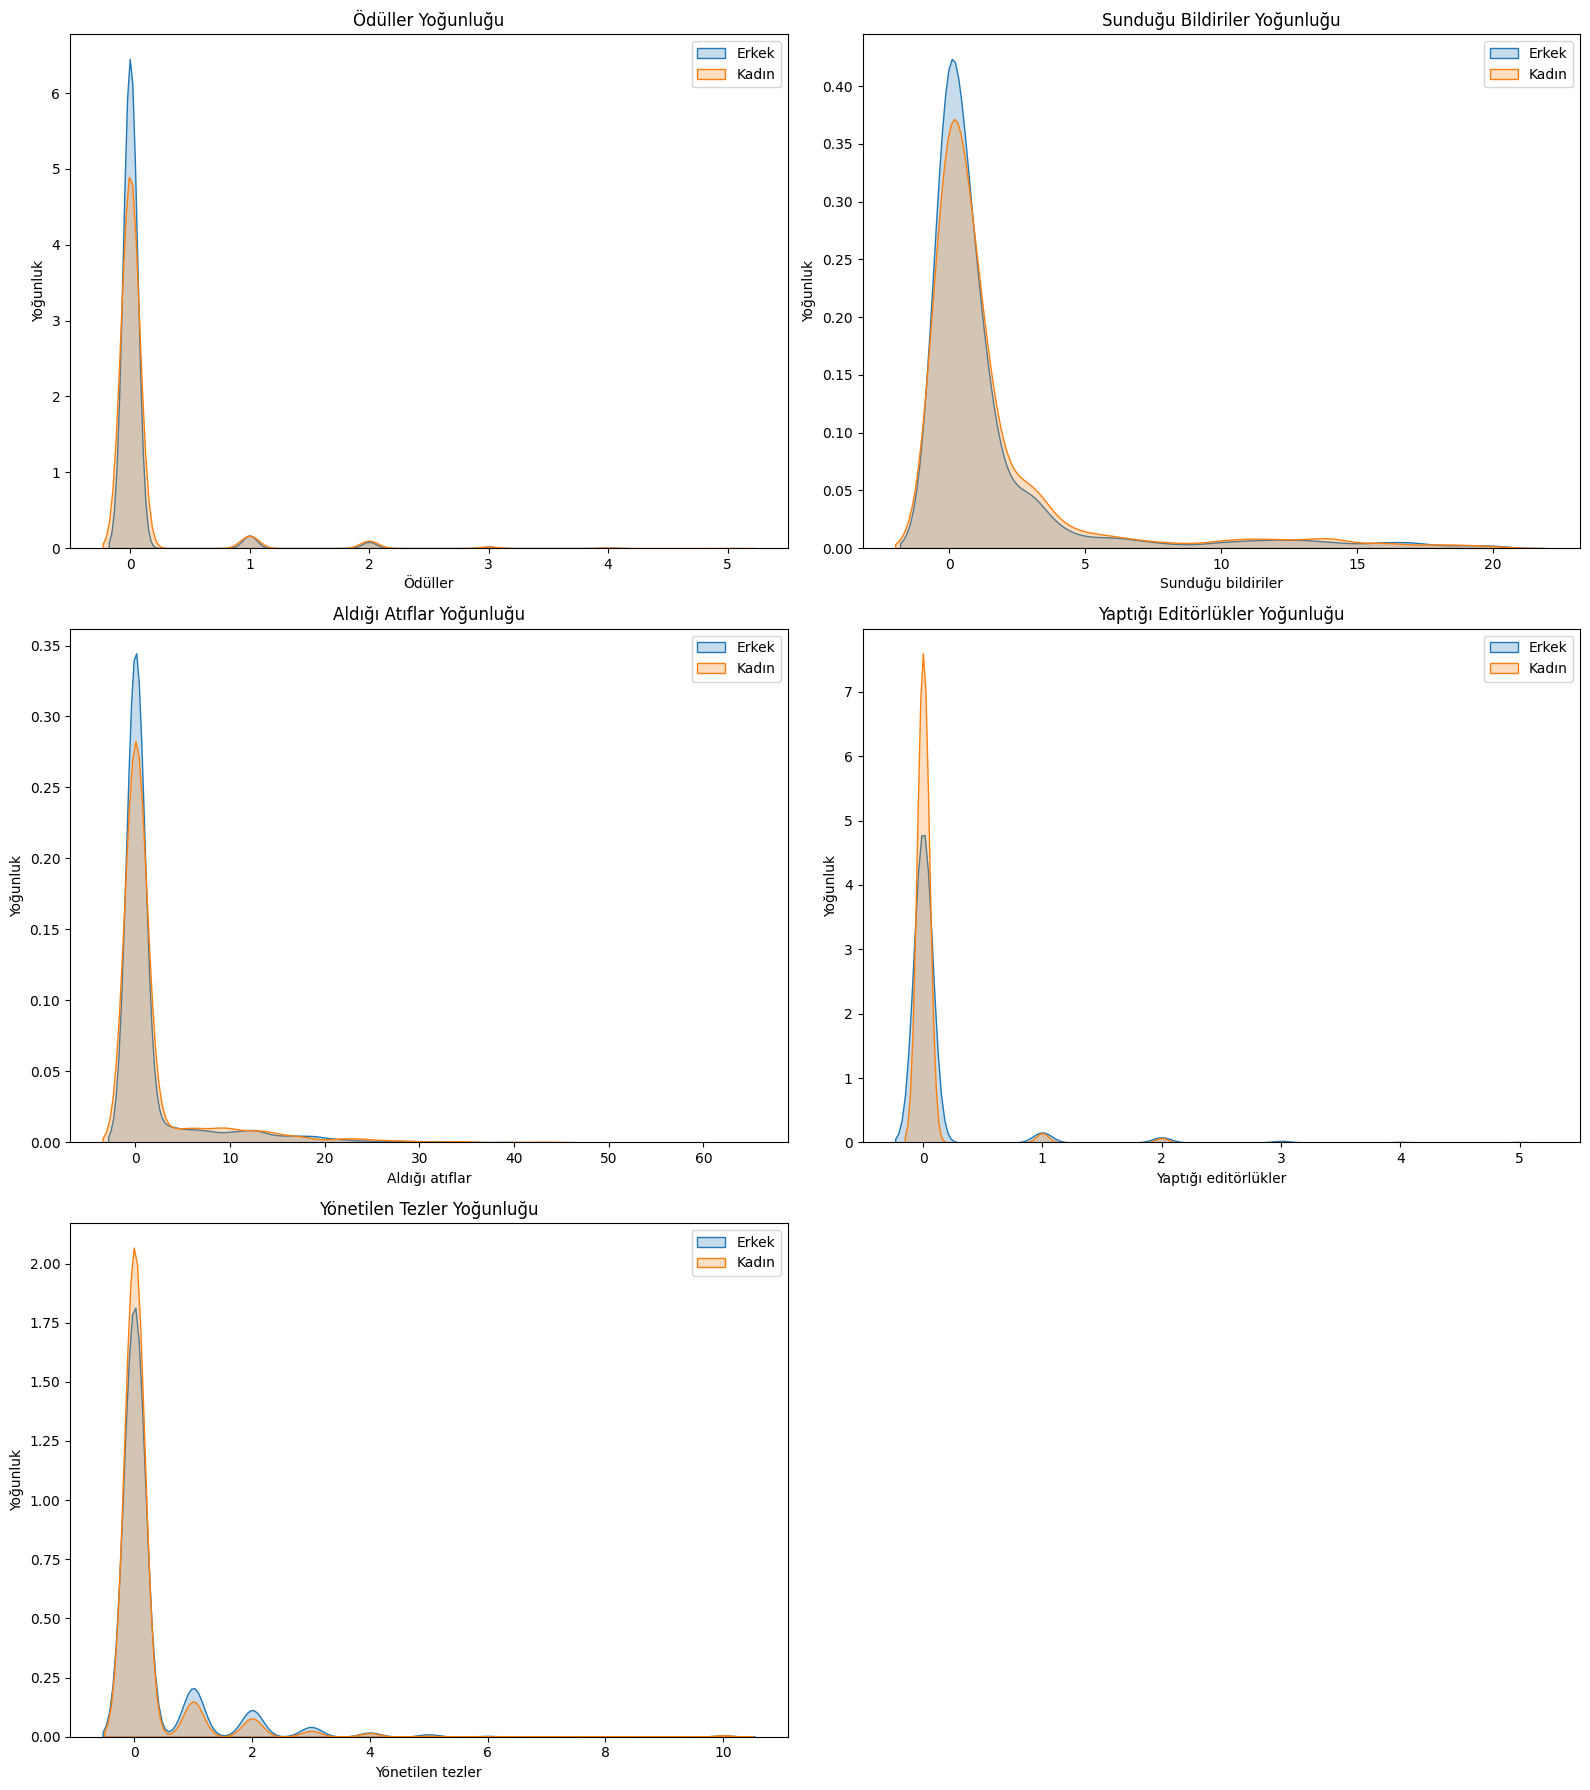

In [109]:
# KDE grafiği için görselleştirme fonksiyonu
def plot_kde(data, column, ax, title):
    sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
    sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Kadın'][column], ax=ax, label='Kadın', shade=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Yoğunluk')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Ödüller KDE Grafiği
plot_kde(df_cleaned, 'Ödüller', axes[0, 0], 'Ödüller Yoğunluğu')

# Sunduğu Bildiriler KDE Grafiği
plot_kde(df_cleaned, 'Sunduğu bildiriler', axes[0, 1], 'Sunduğu Bildiriler Yoğunluğu')

# Aldığı Atıflar KDE Grafiği
plot_kde(df_cleaned, 'Aldığı atıflar', axes[1, 0], 'Aldığı Atıflar Yoğunluğu')

# Yaptığı Editörlükler KDE Grafiği
plot_kde(df_cleaned, 'Yaptığı editörlükler', axes[1, 1], 'Yaptığı Editörlükler Yoğunluğu')

# Yönetilen Tezler KDE Grafiği
plot_kde(df_cleaned, 'Yönetilen tezler', axes[2, 0], 'Yönetilen Tezler Yoğunluğu')

# Boş kalan grafiği kaldır
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


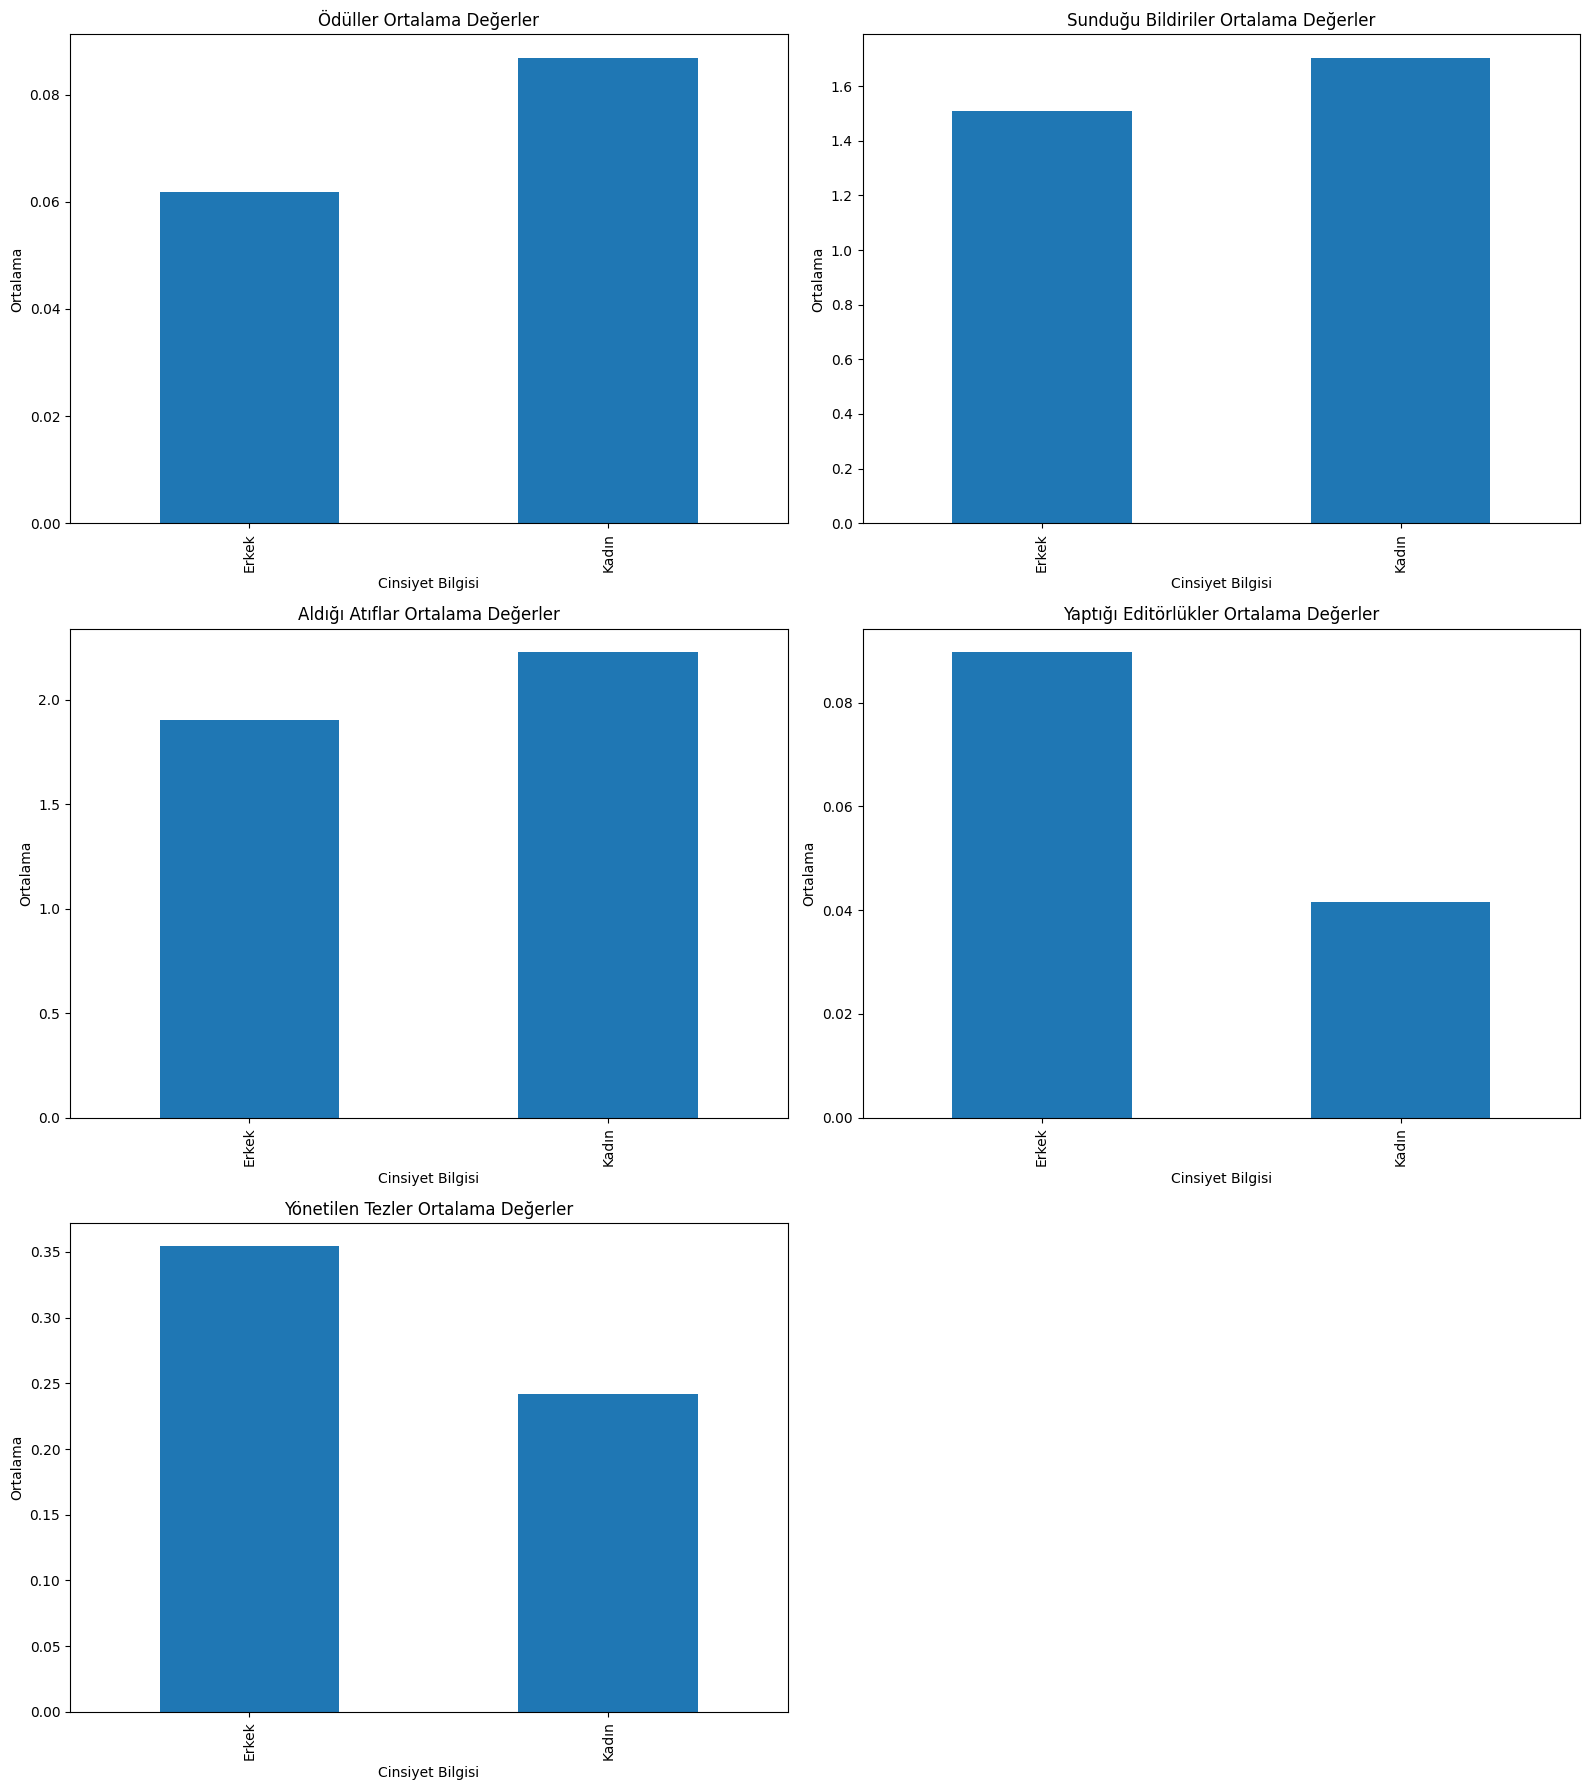

In [110]:
# Ortalama değerler için bar grafik fonksiyonu
def plot_bar(data, column, ax, title):
    means = data.groupby('Cinsiyet Bilgisi')[column].mean()
    means.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cinsiyet Bilgisi')
    ax.set_ylabel('Ortalama')

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Ödüller Bar Grafiği
plot_bar(df_cleaned, 'Ödüller', axes[0, 0], 'Ödüller Ortalama Değerler')

# Sunduğu Bildiriler Bar Grafiği
plot_bar(df_cleaned, 'Sunduğu bildiriler', axes[0, 1], 'Sunduğu Bildiriler Ortalama Değerler')

# Aldığı Atıflar Bar Grafiği
plot_bar(df_cleaned, 'Aldığı atıflar', axes[1, 0], 'Aldığı Atıflar Ortalama Değerler')

# Yaptığı Editörlükler Bar Grafiği
plot_bar(df_cleaned, 'Yaptığı editörlükler', axes[1, 1], 'Yaptığı Editörlükler Ortalama Değerler')

# Yönetilen Tezler Bar Grafiği
plot_bar(df_cleaned, 'Yönetilen tezler', axes[2, 0], 'Yönetilen Tezler Ortalama Değerler')

# Boş kalan grafiği kaldır
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


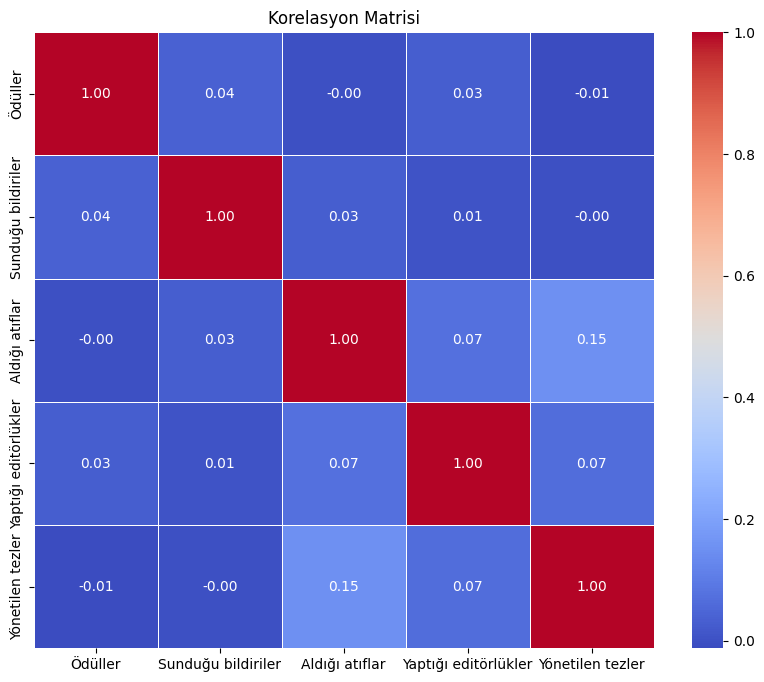

In [111]:
# Korelasyon matrisini hesaplama
correlation_matrix = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']].corr()

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasyon Matrisi')
plt.show()


Regresyon ve Sınıflandırma Analizleri

In [112]:
# Cinsiyet Bilgisi sütununu sayısal verilere dönüştürme
df_cleaned['Cinsiyet Bilgisi'] = df_cleaned['Cinsiyet Bilgisi'].map({'Kadın': 0, 'Erkek': 1})

In [113]:
# Regresyon Modelleri
# Özellikler ve hedef değişkenlerin belirlenmesi
features = ['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']
X = df_cleaned[features]
y = df_cleaned['Cinsiyet Bilgisi']  # Hedef değişken 'Cinsiyet Bilgisi'

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model listesini oluşturma
models1 = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'LogisticRegression': LogisticRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Modelleri eğitme ve değerlendirme

for name, model in models1.items():
    # Modeli eğitme
    model.fit(X_train, y_train)
    
    # Tahmin yapma
    y_pred = model.predict(X_test)
    
    # MSE ve R2 hesaplama
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Modeli:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2: {r2:.4f}")
    print()

Linear Regression Modeli:
  MSE: 0.2409
  R2: 0.0091

Ridge Regression Modeli:
  MSE: 0.2409
  R2: 0.0091

LogisticRegression Modeli:
  MSE: 0.4176
  R2: -0.7180

Lasso Regression Modeli:
  MSE: 0.2431
  R2: -0.0000

Random Forest Regressor Modeli:
  MSE: 0.2569
  R2: -0.0569

Gradient Boosting Regressor Modeli:
  MSE: 0.2397
  R2: 0.0142

SVR Modeli:
  MSE: 0.3285
  R2: -0.3515



In [114]:
# Sınıflandırma Modelleri
# Uyarıları bastırma
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Özellikler ve hedef değişken
X = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']]
y = df_cleaned['Cinsiyet Bilgisi']  # 'Cinsiyet Bilgisi' hedef değişken olarak seçildi

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model listesini oluşturma
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier(verbosity=-1)
}

# Modelleri eğitme ve değerlendirme
for name, model in models.items():
    try:
        # Modeli eğitme
        model.fit(X_train, y_train)
        
        # Tahmin yapma
        y_pred = model.predict(X_test)
        
        # Performans değerlendirme
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1)  # veya 'Erkek' hangi etiket üzerinde değerlendireceğinize göre
        recall = recall_score(y_test, y_pred, pos_label=1)  # veya 'Erkek'
        f1 = f1_score(y_test, y_pred, pos_label=1)  # veya 'Erkek'
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f"{name} Modeli - Doğruluk (Accuracy): {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print()
    except Exception as e:
        print(f"{name} Modeli için bir hata oluştu: {e}")
        print()


Logistic Regression Modeli - Doğruluk (Accuracy): 0.5824, Precision: 0.5846, Recall: 0.9806, F1 Score: 0.7325

Random Forest Classifier Modeli - Doğruluk (Accuracy): 0.5884, Precision: 0.5983, Recall: 0.8947, F1 Score: 0.7171

Gradient Boosting Classifier Modeli - Doğruluk (Accuracy): 0.5908, Precision: 0.5911, Recall: 0.9673, F1 Score: 0.7338

Support Vector Classifier Modeli - Doğruluk (Accuracy): 0.5838, Precision: 0.5835, Recall: 0.9994, F1 Score: 0.7368

XGBoost Classifier Modeli - Doğruluk (Accuracy): 0.5852, Precision: 0.5960, Recall: 0.8959, F1 Score: 0.7158

LightGBM Classifier Modeli - Doğruluk (Accuracy): 0.5908, Precision: 0.6001, Recall: 0.8941, F1 Score: 0.7182



Support Vector Classifier ve Logistic Regression en iyi performansı gösteriyor. Özellikle Support Vector Classifier yüksek recall ve F1 skoru ile dikkat çekiyor, bu da pozitif sınıfı çok iyi tanımladığını ve dengesiz veri setlerinde etkili olduğunu gösteriyor. Eğer 'Erkek' sınıfını doğru tahmin etmek öncelikli hedefse, Support Vector Classifier iyi bir seçim olabilir. 

SVC

In [115]:
# Özellikler ve hedef değişken
X = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']]
y = df_cleaned['Cinsiyet Bilgisi']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeli tanımlama ve eğitme
model = SVC()  # Varsayılan hiperparametrelerle SVC modeli
model.fit(X_train, y_train)

# Tahmin yapma
y_pred = model.predict(X_test)

# Performans değerlendirme
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)  # Erkek= 1 olarak belirlendi
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Doğruluk (Accuracy): 0.5838
Precision: 0.5835
Recall: 0.9994
F1 Score: 0.7368
Confusion Matrix:
[[   3 1179]
 [   1 1652]]


In [116]:
# Modeli tanımlama
svc_model = SVC()

# Çapraz doğrulama
cv_scores = cross_val_score(svc_model, X, y, cv=5, scoring='accuracy')

# Çapraz doğrulama sonuçlarını yazdırma
print(f"Çapraz Doğrulama - Ortalama Doğruluk: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Çapraz Doğrulama - Ortalama Doğruluk: 0.5767 ± 0.0062


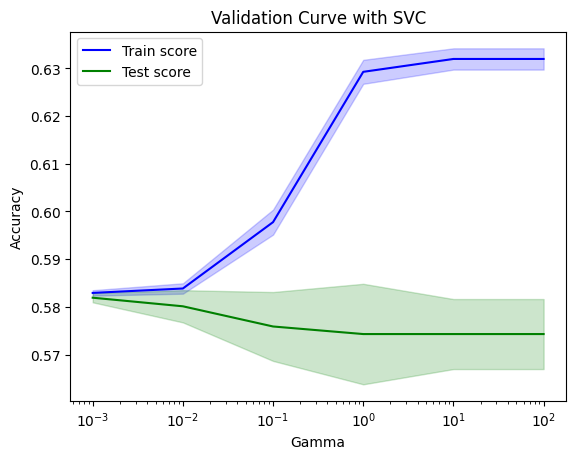

In [117]:
# Çekirdek fonksiyonu için gamma'nın doğruluğunu inceleme
param_range = np.logspace(-3, 2, 6)
train_scores, test_scores = validation_curve(
    svc_model,
    X, y,
    param_name='gamma',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

# Ortalama doğrulukları hesaplama
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Karmaşıklık analizini çizme
plt.figure()
plt.semilogx(param_range, train_mean, label='Train score', color='blue')
plt.semilogx(param_range, test_mean, label='Test score', color='green')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.title('Validation Curve with SVC')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

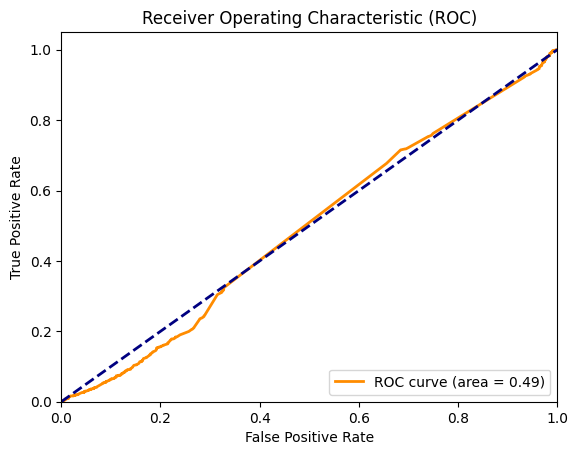

In [118]:
# Modeli tanımlama ve eğitim
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)

# Tahmin olasılıkları
y_prob = svc_model.predict_proba(X_test)[:, 1]

# ROC eğrisi verileri
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [119]:
# Erken Durdurma Uygulaması
# Veriyi eğitim ve doğrulama setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelinizi eğitim ve doğrulama setleri ile eğitme
# Basit bir model tanımlama
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Erken Durdurma
early_stopping = EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik
    patience=5,          # Sabırlı bekleme süresi
    min_delta=0.001,     # İyileşme miktarı
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

# Modeli eğitim ve doğrulama setleri ile eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5685 - loss: 0.6856 - val_accuracy: 0.5852 - val_loss: 0.6700
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5818 - loss: 0.6763 - val_accuracy: 0.5836 - val_loss: 0.6825
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.5775 - loss: 0.6819 - val_accuracy: 0.5931 - val_loss: 0.6677
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.5783 - loss: 0.6791 - val_accuracy: 0.5873 - val_loss: 0.6696
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 0.6778 - val_accuracy: 0.5836 - val_loss: 0.6687
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5772 - loss: 0.6764 - val_accuracy: 0.5794 - val_loss: 0.6703
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5801 - loss: 0.6762 - val_accuracy: 0.5852 - val_loss: 0.6688
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5782 - loss: 0.6738 - val_accuracy: 

In [120]:
# Test seti tahminleri
y_test_pred_prob = model.predict(X_test)  # Tahminler sürekli değerler
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Eşik değerini 0.5 olarak kullanarak ikili sınıflara dönüştürme

# Doğruluk skoru
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Seti Doğruluk Skoru: {accuracy:.4f}")

# Diğer performans metrikleri
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred))

# Karışıklık Matrisi
print("Karışıklık Matrisi:")
print(confusion_matrix(y_test, y_test_pred))

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
Test Seti Doğruluk Skoru: 0.5866
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.52      0.13      0.21      1182
           1       0.59      0.91      0.72      1653

    accuracy                           0.59      2835
   macro avg       0.56      0.52      0.46      2835
weighted avg       0.56      0.59      0.51      2835

Karışıklık Matrisi:
[[ 153 1029]
 [ 143 1510]]


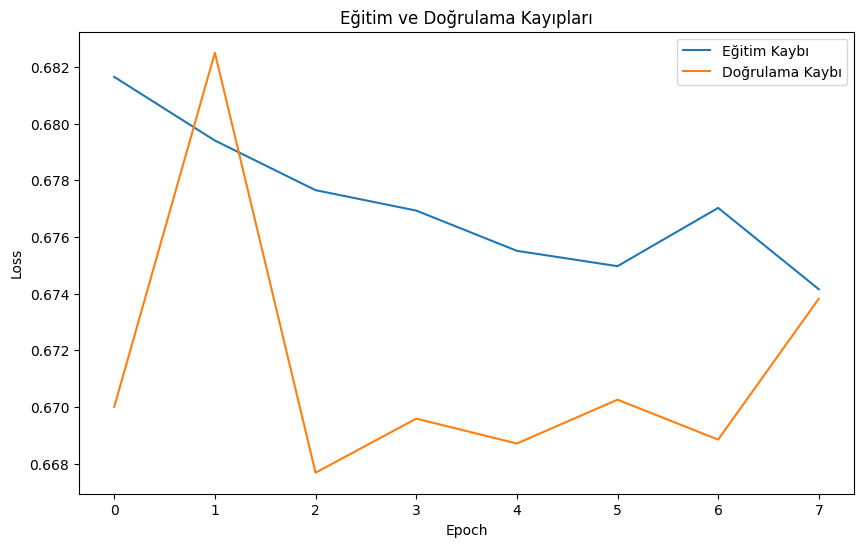

In [121]:
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.show()

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


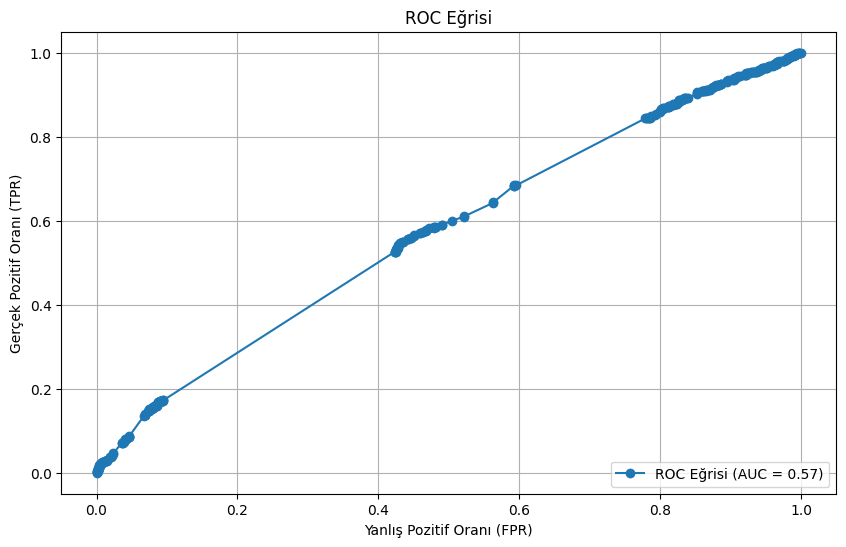

In [122]:
# Olasılık tahminlerini alma
y_test_prob = model.predict(X_test).ravel()  # predict() döndürülen sonuçları 1D diziye dönüştürme

# ROC eğrisini ve AUC'yi hesaplama
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# ROC eğrisini çizme
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', label=f'ROC Eğrisi (AUC = {auc:.2f})')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Gerçek Pozitif Oranı (TPR)')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Zamansal Trendler: Yıllar içinde başarılar ve performans nasıl değişmiş?

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11691 entries, 0 to 11690
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               11691 non-null  object
 1   Yıl(Güncellenmiş)       11691 non-null  object
 2   Akademik Personel Tipi  11691 non-null  object
 3   Cinsiyet Bilgisi        11691 non-null  object
 4   Ödüller                 11691 non-null  int64 
 5   Sunduğu bildiriler      11691 non-null  int64 
 6   Yayınlanmış makale      11691 non-null  int64 
 7   Aldığı atıflar          11691 non-null  int64 
 8   Kitap yazımı            11691 non-null  int64 
 9   Yaptığı editörlükler    11691 non-null  int64 
 10  Yönetilen tezler        11691 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1004.8+ KB


In [124]:
# İlk veri setinden temizlenmiş veri oluşturma
df_year = df.copy()

In [125]:
# İlk veri setinden temizlenmiş veri oluşturma
df_year = df.copy()

# Ödüller için özel sınırlar
valid_awards = (df_year['Ödüller'] >= 0) & (df_year['Ödüller'] <= 5)
df_year = df_year[valid_awards]

# Bildiri Sunma için sınır
valid_presentations = (df_year['Sunduğu bildiriler'] >= 0) & (df_year['Sunduğu bildiriler'] <= 20)
df_year = df_year[valid_presentations]

# Makale Yayınlama için sınır
valid_publications = (df_year['Yayınlanmış makale'] >= 0) & (df_year['Yayınlanmış makale'] <= 20)
df_year = df_year[valid_publications]

# Atıf için sınır
valid_citations = (df_year['Aldığı atıflar'] >= 0) & (df_year['Aldığı atıflar'] <= 100)
df_year = df_year[valid_citations]

# Kitap Yazma için sınır
valid_books = df_year['Kitap yazımı'] < 5
df_year = df_year[valid_books]

# Editörlük için sınır
valid_editorship = (df_year['Yaptığı editörlükler'] >= 0) & (df_year['Yaptığı editörlükler'] <= 5)
df_year = df_year[valid_editorship]

# Tez Yönetimi için sınır
valid_thesis_supervision = (df_year['Yönetilen tezler'] >= 0) & (df_year['Yönetilen tezler'] <= 10)
year = df_year[valid_thesis_supervision]

In [126]:
# Hata kontrolü için kategorik veri içeren sütunların benzersiz değerlerinin görüntülenmesi
# Benzersiz değerlerin listesi

unique_values_person = map(str,df_year['Person ID'].unique())
unique_values_personel = df_year['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df_year['Cinsiyet Bilgisi'].unique()
unique_values_yil = df_year['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 396, 399, 400, 401, 406, 417, 418, 420, 439, 443, 444, 445, 447, 449, 452, 453, 454, 458, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344, 1362, 1382, 1384, 1390, 1404,
1407, 1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 1567, 1572, 1575, 1577, 157

In [127]:
# Üzerinde incelene yapılmayacağından dolayı 'Person ID' sütunu kaldırma
df_year = df_year.drop(columns=['Person ID'])

In [128]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9843 entries, 0 to 11689
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Yıl(Güncellenmiş)       9843 non-null   object
 1   Akademik Personel Tipi  9843 non-null   object
 2   Cinsiyet Bilgisi        9843 non-null   object
 3   Ödüller                 9843 non-null   int64 
 4   Sunduğu bildiriler      9843 non-null   int64 
 5   Yayınlanmış makale      9843 non-null   int64 
 6   Aldığı atıflar          9843 non-null   int64 
 7   Kitap yazımı            9843 non-null   int64 
 8   Yaptığı editörlükler    9843 non-null   int64 
 9   Yönetilen tezler        9843 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 845.9+ KB


In [129]:
# Akademik personel tipini ve cinsiyet bilgisini sayısal verilere dönüştürme
df_year['Akademik Personel Tipi'] = df_year['Akademik Personel Tipi'].map({'Profesör': 0, 'Doçent': 1, 'Doktor Öğretim Üyesi': 2,
                                                                           'Öğretim Görevlisi': 3, 'Araştırma Görevlisi': 4, 'Uzman': 5,
                                                                           'Yabancı Uyruklu Öğretim Elemanları': 6, ' GİH': 7, 'Görevlendirme': 8,
                                                                           'TUS': 9})
df_year['Cinsiyet Bilgisi'] = df_year['Cinsiyet Bilgisi'].map({'Kadın': 0, 'Erkek': 1})


In [130]:
# Sayısal dönüşümlerin listesi
personel_tipi_mapping = {
    0: 'Profesör',
    1: 'Doçent',
    2: 'Doktor Öğretim Üyesi',
    3: 'Öğretim Görevlisi',
    4: 'Araştırma Görevlisi',
    5: 'Uzman',
    6: 'Yabancı Uyruklu Öğretim Elemanları',
    7: 'GİH',
    8: 'Görevlendirme',
    9: 'TUS'
}

cinsiyet_mapping = {
    0: 'Kadın',
    1: 'Erkek'
}

print("Akademik Personel Tipi Dönüşümleri:")
for key, value in personel_tipi_mapping.items():
    print(f"{key}: {value}")

print("\nCinsiyet Bilgisi Dönüşümleri:")
for key, value in cinsiyet_mapping.items():
    print(f"{key}: {value}")


Akademik Personel Tipi Dönüşümleri:
0: Profesör
1: Doçent
2: Doktor Öğretim Üyesi
3: Öğretim Görevlisi
4: Araştırma Görevlisi
5: Uzman
6: Yabancı Uyruklu Öğretim Elemanları
7: GİH
8: Görevlendirme
9: TUS

Cinsiyet Bilgisi Dönüşümleri:
0: Kadın
1: Erkek


In [131]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9843 entries, 0 to 11689
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Yıl(Güncellenmiş)       9843 non-null   object 
 1   Akademik Personel Tipi  9842 non-null   float64
 2   Cinsiyet Bilgisi        9843 non-null   int64  
 3   Ödüller                 9843 non-null   int64  
 4   Sunduğu bildiriler      9843 non-null   int64  
 5   Yayınlanmış makale      9843 non-null   int64  
 6   Aldığı atıflar          9843 non-null   int64  
 7   Kitap yazımı            9843 non-null   int64  
 8   Yaptığı editörlükler    9843 non-null   int64  
 9   Yönetilen tezler        9843 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 845.9+ KB


In [132]:
# Yıl ve başarı metriklerinin seçilmesi
df_year['Yıl(Güncellenmiş)'] = pd.to_datetime(df_year['Yıl(Güncellenmiş)'], errors='coerce', format='%Y')  # Yıl sütununu datetime formatına dönüştürme
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9843 entries, 0 to 11689
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Yıl(Güncellenmiş)       9841 non-null   datetime64[ns]
 1   Akademik Personel Tipi  9842 non-null   float64       
 2   Cinsiyet Bilgisi        9843 non-null   int64         
 3   Ödüller                 9843 non-null   int64         
 4   Sunduğu bildiriler      9843 non-null   int64         
 5   Yayınlanmış makale      9843 non-null   int64         
 6   Aldığı atıflar          9843 non-null   int64         
 7   Kitap yazımı            9843 non-null   int64         
 8   Yaptığı editörlükler    9843 non-null   int64         
 9   Yönetilen tezler        9843 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 845.9 KB


In [133]:
# Yıl sütununu indeks olarak ayarlama
df_year.set_index('Yıl(Güncellenmiş)', inplace=True)  # Yıl sütununu index olarak ayarlama

In [134]:
df_year.index = pd.to_datetime(df_year.index)

In [135]:
# Her yıl için ortalama başarı metriklerini hesaplama
annual_metrics = df_year.resample('Y').mean()  # Yıllık ortalama hesaplama

In [136]:
# Akademik Personel Tipi ve Cinsiyet Bilgisi için yıllık frekans hesaplama
personel_freq = df_year.groupby([df_year.index.year, 'Akademik Personel Tipi']).size().unstack().fillna(0)
cinsiyet_freq = df_year.groupby([df_year.index.year, 'Cinsiyet Bilgisi']).size().unstack().fillna(0)

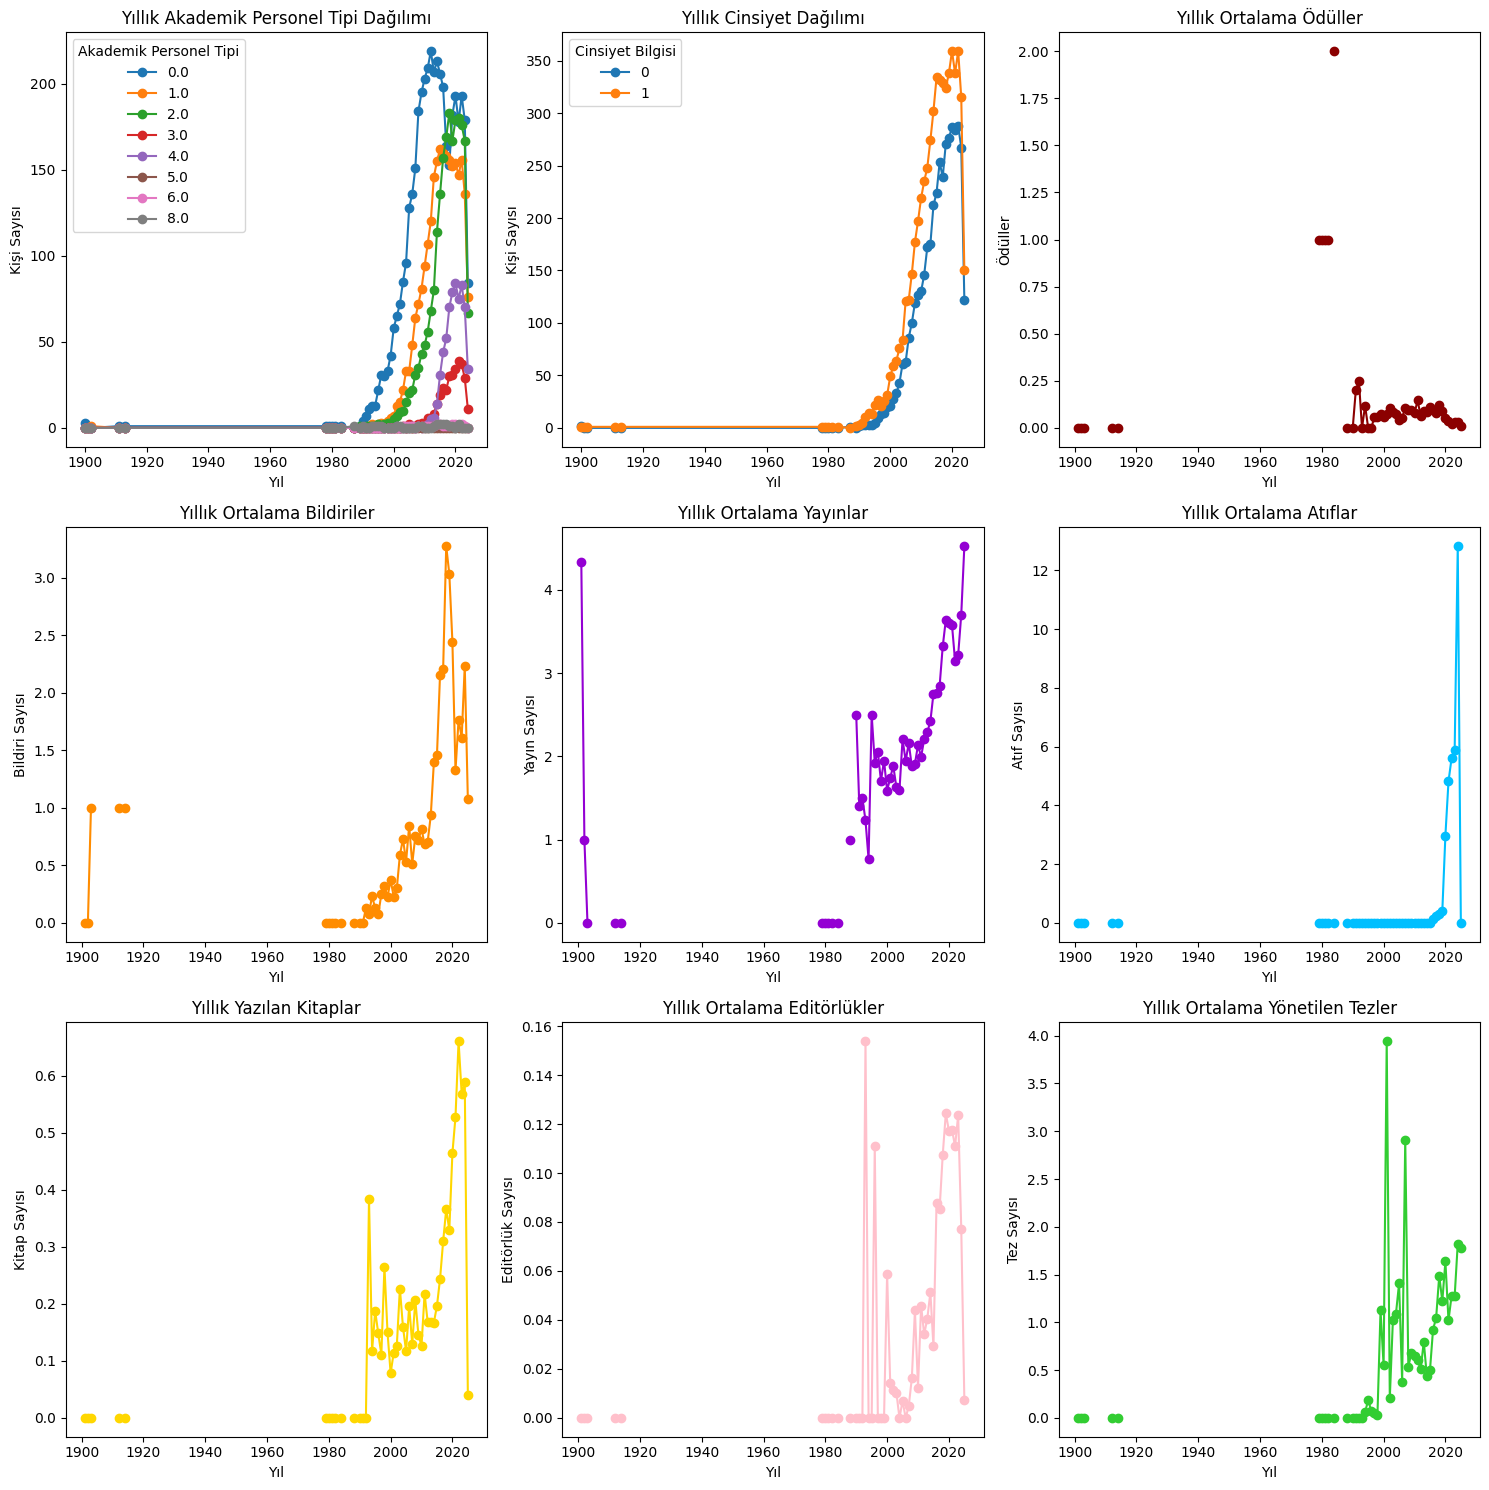

In [137]:
# Grafiklerin oluşturulması
plt.figure(figsize=(15, 15))

# Akademik personel tipi grafiği
plt.subplot(3, 3, 1)
personel_freq.plot(ax=plt.gca(), marker='o', linestyle='-', title='Yıllık Akademik Personel Tipi Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Kişi Sayısı')

# Cinsiyet bilgisi grafiği
plt.subplot(3, 3, 2)
cinsiyet_freq.plot(ax=plt.gca(), marker='o', linestyle='-', title='Yıllık Cinsiyet Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Kişi Sayısı')

# Ödüller grafiği
plt.subplot(3, 3, 3)
plt.plot(annual_metrics.index, annual_metrics['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Ortalama Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Ödüller')

# Bildiriler grafiği
plt.subplot(3, 3, 4)
plt.plot(annual_metrics.index, annual_metrics['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Ortalama Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Bildiri Sayısı')

# Yayınlar grafiği
plt.subplot(3, 3, 5)
plt.plot(annual_metrics.index, annual_metrics['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Ortalama Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Yayın Sayısı')

# Atıflar grafiği
plt.subplot(3, 3, 6)
plt.plot(annual_metrics.index, annual_metrics['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Ortalama Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Atıf Sayısı')

# Kitaplar grafiği
plt.subplot(3, 3, 7)
plt.plot(annual_metrics.index, annual_metrics['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Yazılan Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Kitap Sayısı')

# Editörlükler grafiği
plt.subplot(3, 3, 8)
plt.plot(annual_metrics.index, annual_metrics['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Ortalama Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Editörlük Sayısı')

# Tezler grafiği
plt.subplot(3, 3, 9)
plt.plot(annual_metrics.index, annual_metrics['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Ortalama Yönetilen Tezler')
plt.xlabel('Yıl')
plt.ylabel('Tez Sayısı')

plt.tight_layout()
plt.show()

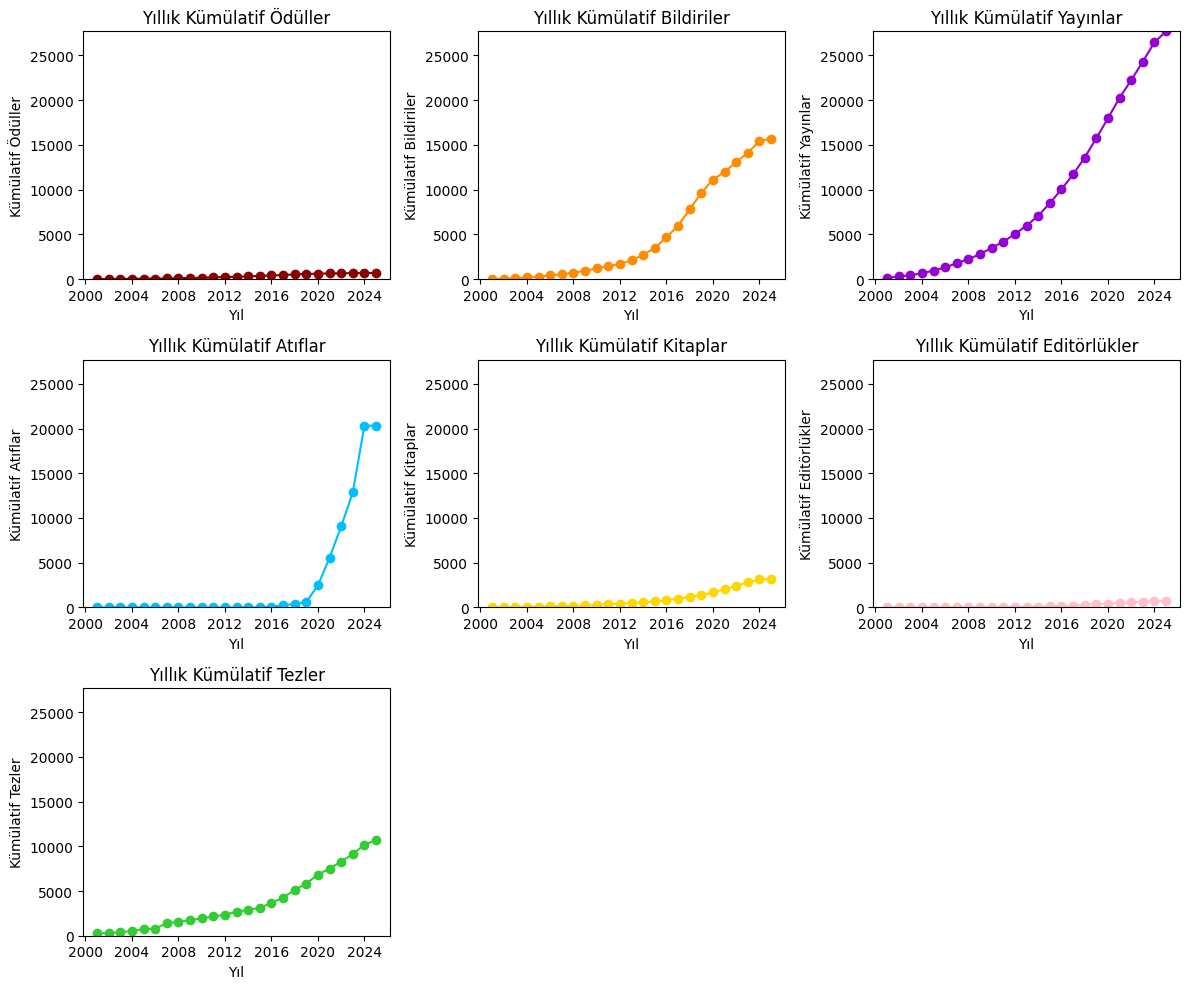

In [138]:
# Kümülatif Toplamların Hesaplanması
# 2000 yılından itibaren verileri filtreleme
df_year = df_year[df_year.index.year >= 2000]

# Yıllık başarı metriklerinin kümülatif toplamlarının hesaplanması
cumulative_metrics = df_year.resample('Y').sum().cumsum()

# Y ekseninin aralığını belirlemek için tüm kümülatif metriklerin maksimum ve minimum değerlerini hesaplama
min_y = cumulative_metrics.min().min()
max_y = cumulative_metrics.max().max()

# Grafiklerin oluşturulması
plt.figure(figsize=(12, 10))

# Ödüller grafiği
plt.subplot(3, 3, 1)
plt.plot(cumulative_metrics.index, cumulative_metrics['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Kümülatif Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Ödüller')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Bildiriler grafiği
plt.subplot(3, 3, 2)
plt.plot(cumulative_metrics.index, cumulative_metrics['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Kümülatif Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Bildiriler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Yayınlar grafiği
plt.subplot(3, 3, 3)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Kümülatif Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Yayınlar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Atıflar grafiği
plt.subplot(3, 3, 4)
plt.plot(cumulative_metrics.index, cumulative_metrics['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Kümülatif Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Atıflar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Kitaplar grafiği
plt.subplot(3, 3, 5)
plt.plot(cumulative_metrics.index, cumulative_metrics['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Kümülatif Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Kitaplar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Editörlükler grafiği
plt.subplot(3, 3, 6)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Kümülatif Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Editörlükler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Tezler grafiği
plt.subplot(3, 3, 7)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Kümülatif Tezler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Tezler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

plt.tight_layout()
plt.show()

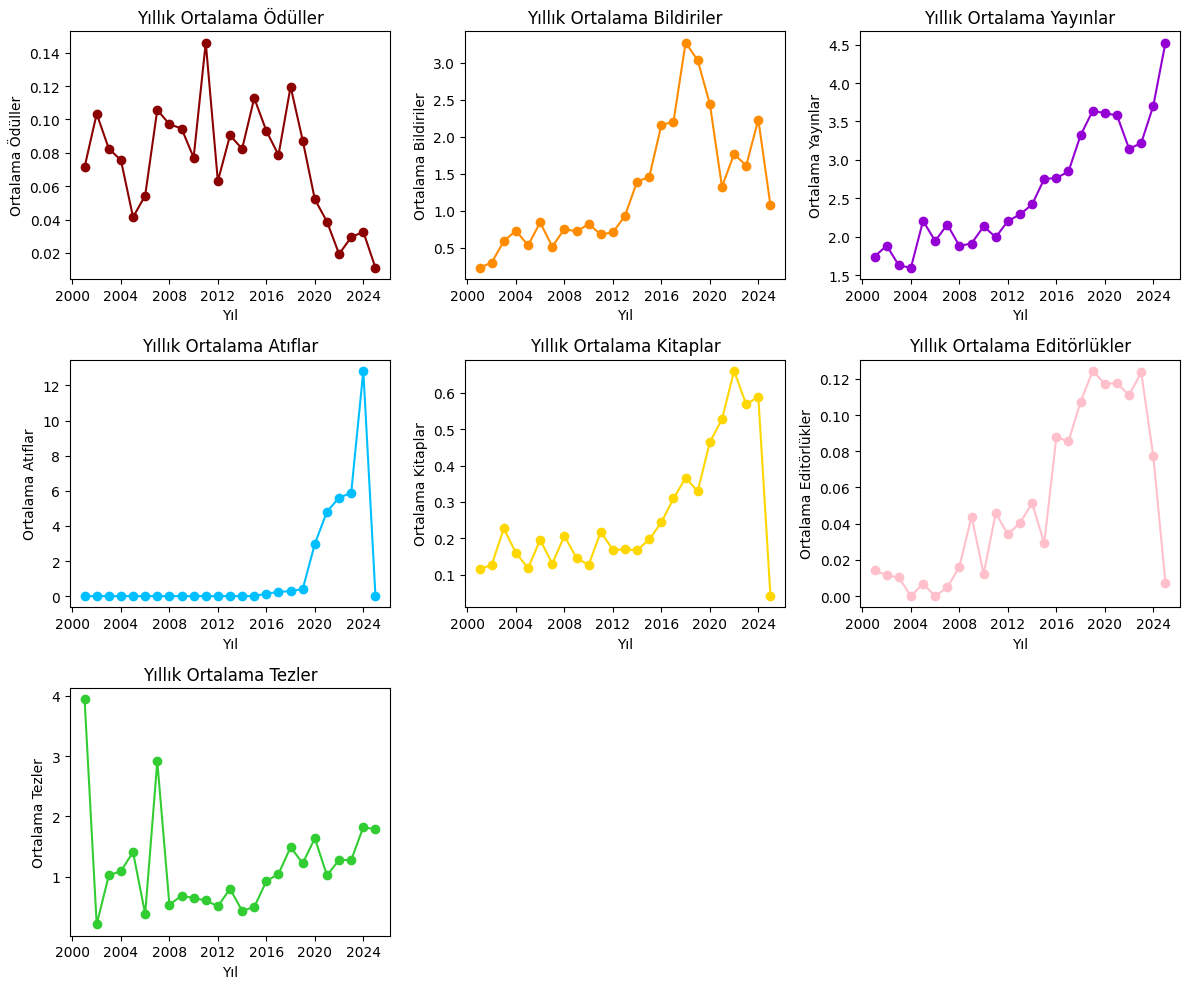

In [139]:
# 2000 yılından itibaren verileri filtreleme
df_year = df_year[df_year.index.year >= 2000]

# Yıllık ortalama başarı metriklerinin hesaplanması
annual_means = df_year.resample('Y').mean()

# Grafiklerin oluşturulması
plt.figure(figsize=(12, 10))

# Ödüller grafiği
plt.subplot(3, 3, 1)
plt.plot(annual_means.index, annual_means['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Ortalama Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Ödüller')

# Bildiriler grafiği
plt.subplot(3, 3, 2)
plt.plot(annual_means.index, annual_means['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Ortalama Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Bildiriler')

# Yayınlar grafiği
plt.subplot(3, 3, 3)
plt.plot(annual_means.index, annual_means['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Ortalama Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Yayınlar')

# Atıflar grafiği
plt.subplot(3, 3, 4)
plt.plot(annual_means.index, annual_means['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Ortalama Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Atıflar')

# Kitaplar grafiği
plt.subplot(3, 3, 5)
plt.plot(annual_means.index, annual_means['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Ortalama Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Kitaplar')

# Editörlükler grafiği
plt.subplot(3, 3, 6)
plt.plot(annual_means.index, annual_means['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Ortalama Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Editörlükler')

# Tezler grafiği
plt.subplot(3, 3, 7)
plt.plot(annual_means.index, annual_means['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Ortalama Tezler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Tezler')

plt.tight_layout()
plt.show()

In [140]:
# Hareketli Ortalama hesaplama (12 aylık hareketli ortalama)
metrics = ['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']

for metric in metrics:
    df_year[f'{metric} Hareketli Ortalama'] = df_year[metric].rolling(window=12).mean()


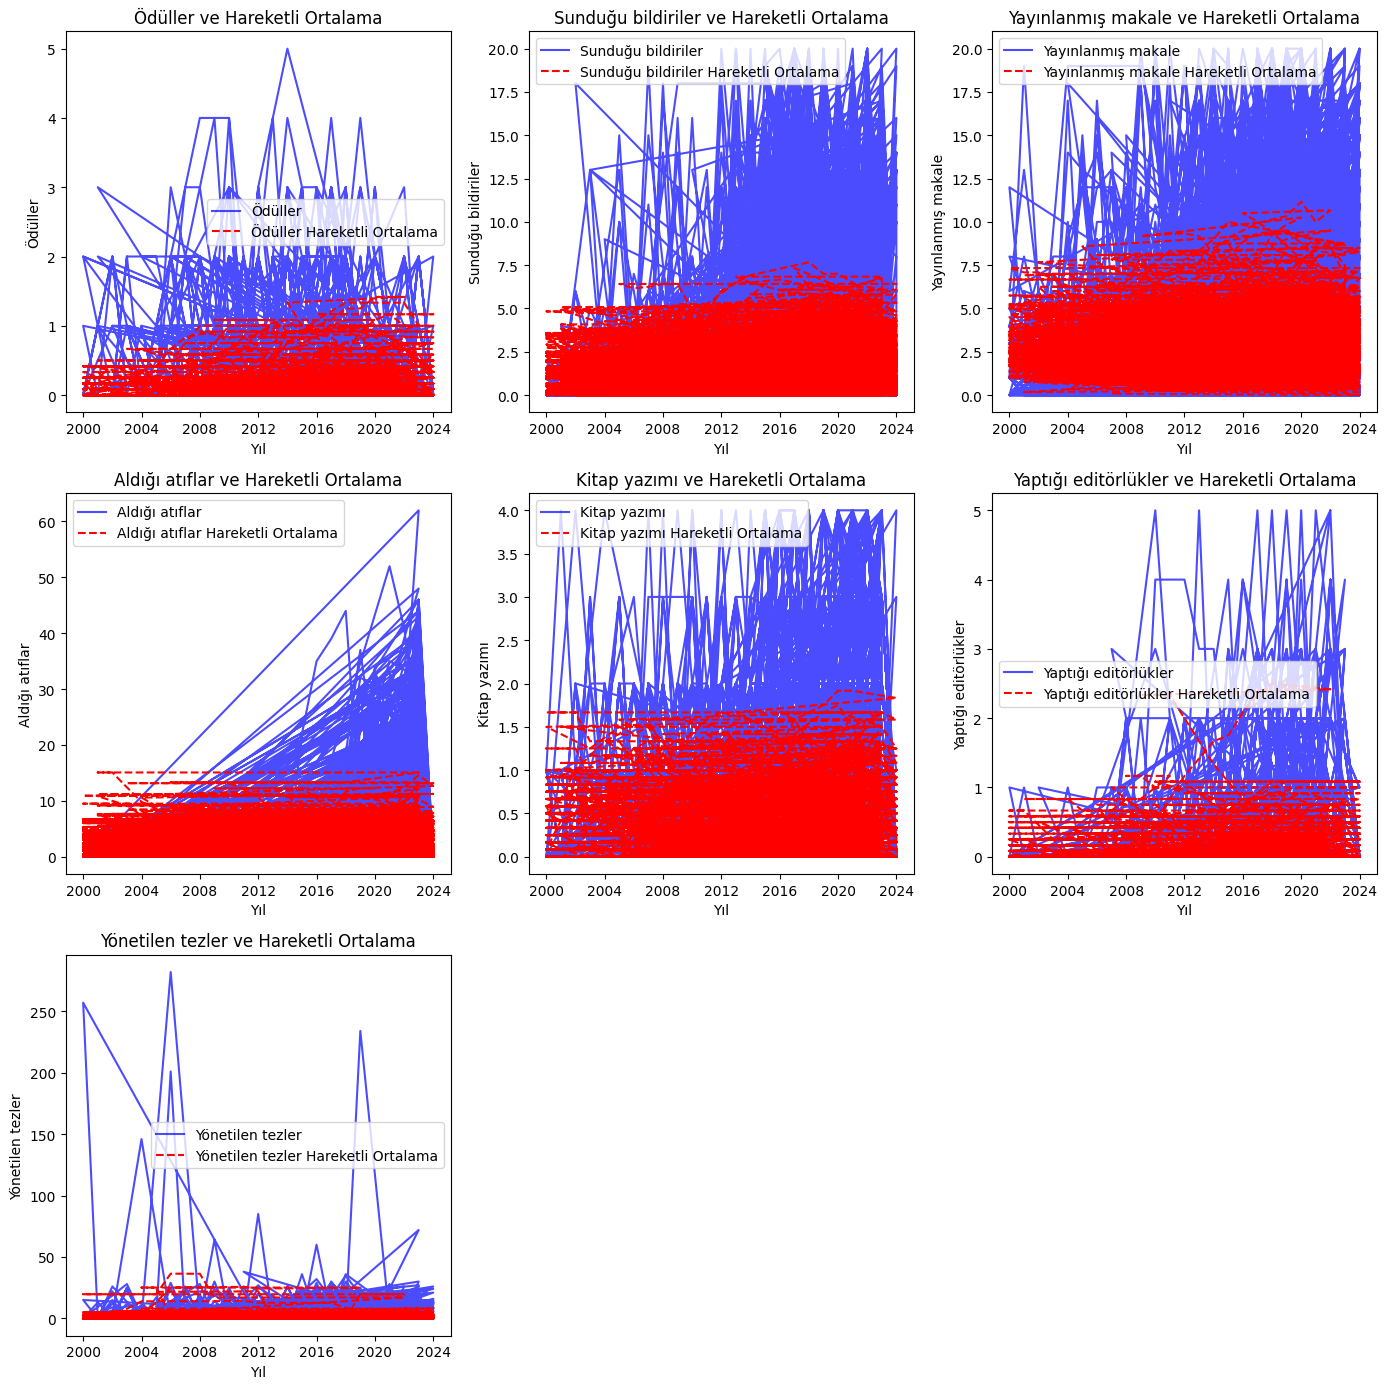

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))

# Grafiklerin oluşturulması
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_year.index, df_year[metric], label=f'{metric}', color='blue', alpha=0.7)
    plt.plot(df_year.index, df_year[f'{metric} Hareketli Ortalama'], label=f'{metric} Hareketli Ortalama', color='red', linestyle='--')
    plt.title(f'{metric} ve Hareketli Ortalama')
    plt.xlabel('Yıl')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


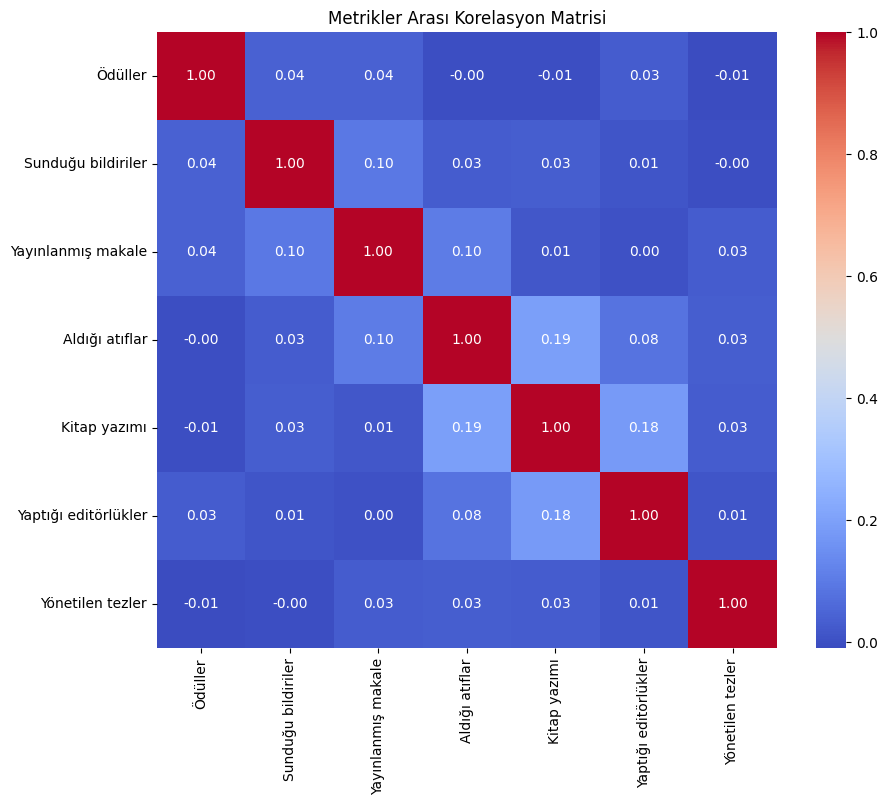

In [142]:
# Korelasyon matrisini hesapla
correlation_matrix = df_year[metrics].corr()

# Korelasyon matrisini görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Metrikler Arası Korelasyon Matrisi')
plt.show()

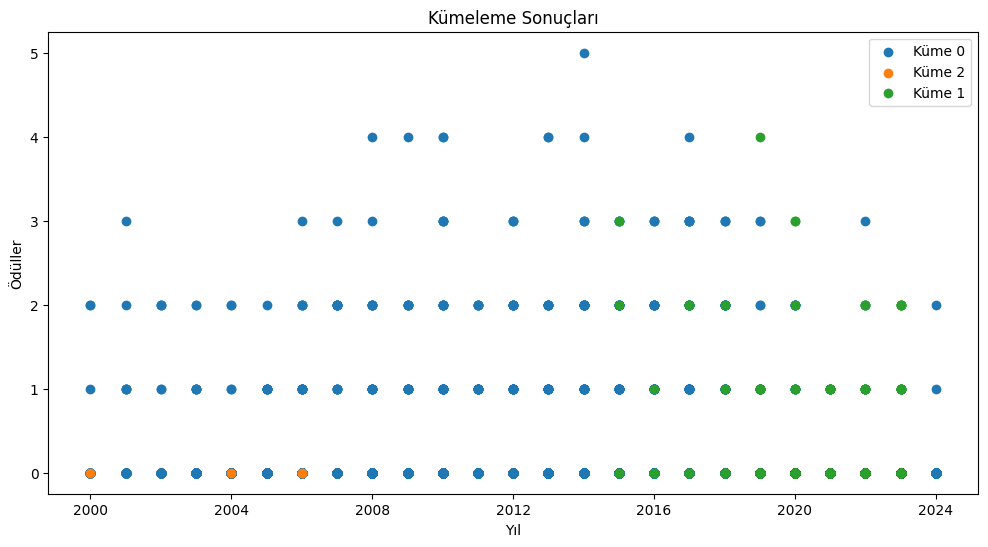

In [149]:
# Özelliklerinizi seçin ve kümeleme yapın
X = df_year[metrics].dropna()  # Eksik verileri düşür
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_year['Cluster'] = kmeans.labels_

# Kümeleme sonuçlarını görselleştirin
plt.figure(figsize=(12, 6))
for cluster in df_year['Cluster'].unique():
    cluster_data = df_year[df_year['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Ödüller'], label=f'Küme {cluster}')

plt.xlabel('Yıl')
plt.ylabel('Ödüller')
plt.title('Kümeleme Sonuçları')
plt.legend()
plt.show()

c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not mo

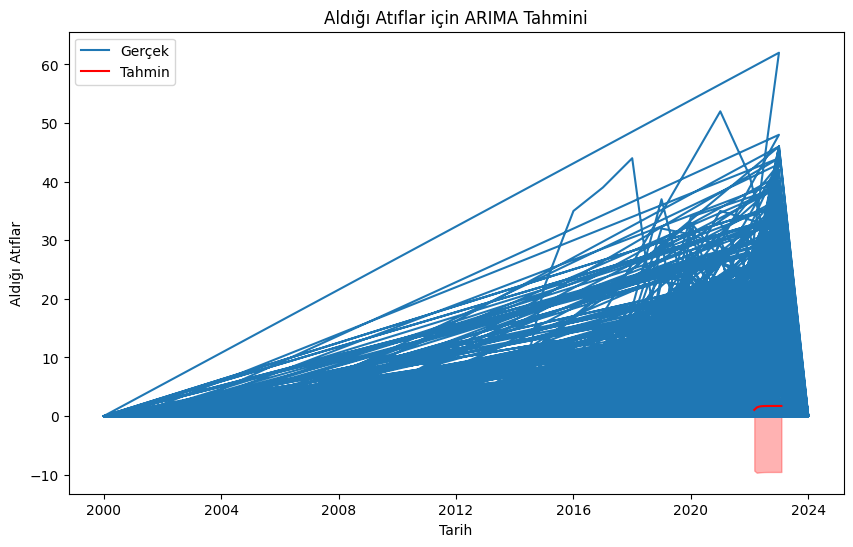

In [153]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Örnek: "Aldığı atıflar" için ARIMA modeli
model = ARIMA(df_year['Aldığı atıflar'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

# Tahminler ve güven aralıkları
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=df_year.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
conf_int = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(df_year.index, df_year['Aldığı atıflar'], label='Gerçek')
plt.plot(forecast_index, forecast.predicted_mean, label='Tahmin', color='red')
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.xlabel('Tarih')
plt.ylabel('Aldığı Atıflar')
plt.title('Aldığı Atıflar için ARIMA Tahmini')
plt.legend()
plt.show()


c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not mo

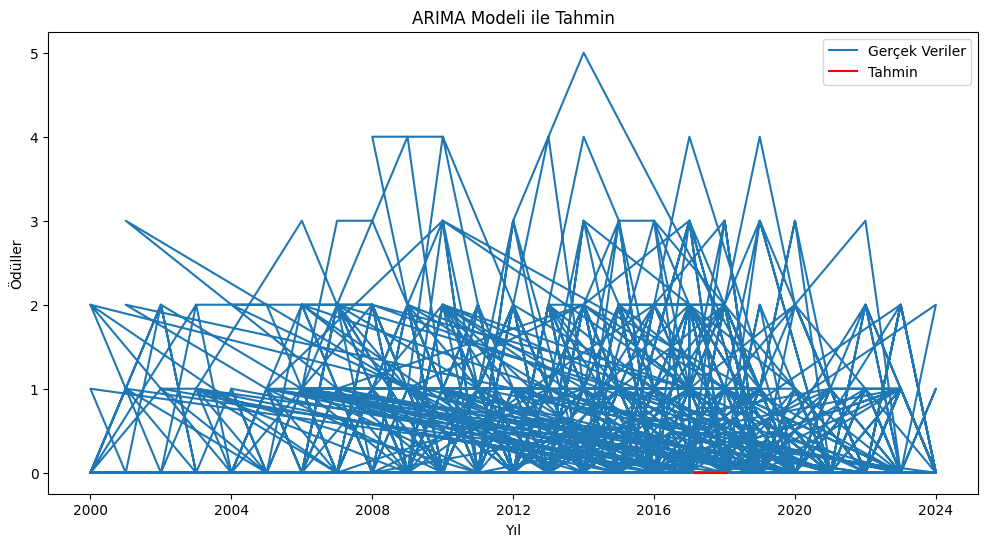

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_year['Ödüller'], order=(5, 1, 0))  # (p,d,q) parametreleri ile ARIMA modeli oluşturma
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)  # 12 ay sonrasını tahmin etme
plt.figure(figsize=(12, 6))
plt.plot(df_year.index, df_year['Ödüller'], label='Gerçek Veriler')
plt.plot(pd.date_range(start=df_year.index[-1], periods=13, freq='M')[1:], forecast, color='red', label='Tahmin')
plt.title('ARIMA Modeli ile Tahmin')
plt.xlabel('Yıl')
plt.ylabel('Ödüller')
plt.legend()
plt.show()